# Contents
## Experiment Set 1 and Set 2
[**A. Clustering Analysis on Numerical Attributes**](#numerical)  
* [K-Means Clustering](#numerical_kmeans)
* [Agglomerative Clustering](#numerical_agglomerative)
* [Best Clustering Model](#numerical_best)
* [Recommend Nearest Neighbors](#numerical_neighbors)

[**B. Clustering Analysis on Categorical Attributes**](#categorical)  
* [K-Modes Clustering](#categorical_kmodes)
* [Agglomerative Clustering](#categorical_agglomerative)
* [Best Clustering Model](#categorical_best)
* [Recommend Nearest Neighbors](#categorical_neighbors)

[**C. Summary**](#summary)

## Experiment Set 3
[**Association Rules Mining**](#association_all)  
* [One-Hot-Encoding](#onehot_all)
* [Apriori-Algorithm](#apriori_all)
* [Replacing with Movie Titles](#replace_all)
* [Extract Interesting Insights](#insights)

## Experiment Set 4
[**Association Rules Mining on Subsets of Genre**](#association_all)  
* [One-Hot-Encoding](#onehot)
* [Apriori-Algorithm](#apriori)
* [Subsets with Association Rules](#yes)
* [Subsets without Association Rules](#no)
* [Replacing with Movie Titles](#replace)
* [Application of Association Rules](#app)

In this section, we will perform clustering analysis on movies metadata to group similar movies together. Since the distance measures for numerical and categorical attributes are different, we will perform clustering analysis on numerical and categorical attributes separately.

# A. Clustering Analysis on Numerical Attributes<a id=numerical><a>

First, let's import all the necessary libraries for clustering analysis on numerical attributes.

In [1]:
# Libraries for data manipulation
import pandas as pd
import numpy as np
import os
path = "/home/jupyter"
os.chdir(path)
# Libraries for data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Libraries for clustering analysis
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from pywaffle import Waffle

Let's have a look at the movies metadata.

In [2]:
movies_ohe_df = pd.read_csv("movies_metadata_ohe.csv", parse_dates=['release_date'])
movies_ohe_df.loc[:, "release_date"] = movies_ohe_df['release_date'].dt.year
print(movies_ohe_df.shape)
movies_ohe_df.head()

(6919, 992)


id  popularity  release_date  runtime              title  vote_average  \
0   1   21.946943          1995     81.0          Toy Story           7.7   
1   2   17.015539          1995    104.0            Jumanji           6.9   
2   3   11.712900          1995    101.0   Grumpier Old Men           6.5   
3   4    3.859495          1995    127.0  Waiting to Exhale           6.1   
4   6   17.924927          1995    170.0               Heat           7.7   

   vote_count  28 Days/Weeks Later Collection  300 Collection  \
0      5415.0                               0               0   
1      2413.0                               0               0   
2        92.0                               0               0   
3        34.0                               0               0   
4      1886.0                               0               0   

   A Better Tomorrow Collection  ...  Will Smith  Willem Dafoe  \
0                             0  ...           0             0   
1                             0  ...           0             0   
2                             0  ...           0             0   
3                             0  ...           0             0   
4                             0  ...           0             0   

   William H. Macy  William Holden  William Hurt  Winona Ryder  Woody Allen.1  \
0                0               0             0             0              0   
1                0               0             0             0              0   
2                0               0             0             0              0   
3                0               0             0             0              0   
4                0               0             0             0              0   

   Woody Harrelson  Zac Efron  Zoe Saldana  
0                0          0            0  
1                0          0            0  
2                0          0            0  
3                0          0            0  
4                0          0            0  

[5 rows x 992 columns]

We noticed that there are 5 numerical attributes in the movies metadata namely popularity, release_date, runtime, vote_average and vote_count. We will perform clustering analysis on three combinations as follow:
* (popularity, release_date, runtime, vote_average, vote_count)
* (popularity, release_date, vote_average, vote_count)
* (popularity, release_date, vote_count)

Then, the best clustering model and combination will be selected. The best clustering model is selected based on the interpretability of the model. To perform clustering analysis on numerical attributes, let's define some general helper functions.

In [3]:
def select_attribute(full_df, columns):
    """Select subset of attributes.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
    
    Returns:
        DataFrame: DataFrame consisting subset of attributes only
    """

    if type(columns) != list:
        columns = list(columns)
    selected_df = full_df.loc[:, columns]
    
    return selected_df

In [4]:
def min_max_scale(numerical_df):
    """Normalize the numerical attributes into the range of 0 and 1.
    
    Parameters:
        numerical_df (DataFrame): DataFrame consisting numerical attributes only
    
    Returns:
        DataFrame: DataFrame consisting scaled numerical values
    """
    
    scaled_numerical_df = pd.DataFrame(MinMaxScaler().fit_transform(numerical_df), columns=numerical_df.columns)
    
    return scaled_numerical_df

In [5]:
def standardization(numerical_df):
    """Standardize the numerical attributes to have mean of 0 and standard deviation of 1.
     
    Parameters:
        numerical_df (DataFrame): DataFrame consisting numerical attributes only
    
    Returns:
        DataFrame: DataFrame consisting scaled numerical values
    """   
    
    standardized_df = pd.DataFrame(StandardScaler().fit_transform(numerical_df), columns=numerical_df.columns)
    
    return standardized_df

In [6]:
def pca(standardized_df, component_numbers):
    """Perform Principal Component Analysis (PCA) to reduce the dimension of data.
    
    Parameters:
        standardized_df (DataFrame): DataFrame consisting standardized numerical attributes only
        component_numbers (int): Number of principal components to obtain
    
    Returns:
        DataFrame: DataFrame consisting N number of principal components after performing PCA
    """
    
    selector = PCA(n_components=component_numbers)
    pca_df = pd.DataFrame(selector.fit_transform(standardized_df),
                          columns=["principal_component_{}".format(i + 1) for i in range(component_numbers)])
    
    return pca_df

In [7]:
def cluster_centroid_original(label_df):
    """Get the centroid of each cluster in original scale.
    
    Parameters:
        label_df (DataFrame): DataFrame consisting selected attributes with cluster labels
    
    Returns:
        DataFrame: DataFrame consisting centroids of selected attributes for each cluster
    """
    
    cluster_numbers = len(label_df["Cluster"].unique())
    centroid_df = pd.DataFrame(columns=label_df.columns[:-1],
                               index=["Cluster {}".format(i + 1) for i in range(cluster_numbers)])
    for i in range(cluster_numbers):
        subset_df = label_df.loc[label_df["Cluster"] == i + 1, label_df.columns[:-1]]
        centroid_df.iloc[i,:] = subset_df.mean()
    
    return centroid_df

In [8]:
def cluster_waffleplot(cluster_labels, column_names):
    """Use waffleplot to visualize the distribution of clusters.
    
    Parameters:
        cluster_labels (ndarray): Array consisting cluster labels
        column_names (tuple): Tuple specifying the selected column names
    
    Display:
        Waffleplot: Waffleplot showing the distribution of clusters
    """
    
    cluster_numbers = len(set(cluster_labels))
    cluster = {}
    for i in range(cluster_numbers):
        cluster["Cluster {}".format(i + 1)] = sum(cluster_labels == i + 1) / len(cluster_labels) * 100
    plt.style.use("ggplot")
    legend_col = len(cluster)
    if len(cluster) > 5:
        legend_col = 5
    fig = plt.figure(FigureClass=Waffle, rows=5, values=cluster,
                     title={"label": "Cluster Distribution for Attributes:\n{}".format(column_names)},
                     labels=["{0} ({1})".format(k, int(v/100*len(cluster_labels))) for k, v in cluster.items()],
                     legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': legend_col,
                             'framealpha': 0}, figsize=(10,6))
    fig.gca().set_facecolor('#EEEEEE')
    fig.set_facecolor('#EEEEEE')
    plt.show()

In [9]:
def cluster_scatterplot(label_df, centroid_df, column_names):
    """Use scatterplot to visualize the clusters and centroids.
    
    Paramaters:
        label_df (DataFrame): DataFrame consisting selected_attributes with cluster labels
        centroid_df (DataFrame): DataFrame consisting centroids of selected attributes for each cluster
        column_names (tuple): Tuple specifying the selected column names
    
    Display:
        Scatterplot: Scatterplot of different clusters
    """
    
    plt.style.use("ggplot")
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=label_df.columns[0], y=label_df.columns[1], hue="Cluster", data=label_df, palette="Set2")
    plt.scatter(centroid_df.iloc[:, 0], centroid_df.iloc[:, 1], s=50, c="black")
    plt.title("Scatterplot for Attributes:\n{}".format(column_names))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

## K-Means Clustering<a id=numerical_kmeans><a>

To perform k-means clustering analysis on numerical attributes, let's define some functions specifically for k-means clustering.

In [10]:
def kmeans_elbow_method(full_df, columns, cluster_numbers):
    """Use elbow method to determine the best number of cluster for k-means clustering.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
        cluster_numbers (list): List specifying the number of clusters to test
    
    Display:
        Lineplot: Lineplot showing SSE vs number of k for selected attributes
    """
    
    selected_df = select_attribute(full_df, columns)
    scaled_selected_df = min_max_scale(selected_df)
    sse = {"k": list(), "sse": list()}
    for k in cluster_numbers:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(scaled_selected_df)
        sse["k"].append(k)
        sse["sse"].append(kmeans.inertia_)
    plt.style.use("ggplot")
    plt.figure(figsize=(8,6))
    plt.plot(sse["k"], sse["sse"])
    plt.title("SSE vs Number of k for Attributes:\n{}".format(columns))
    plt.xlabel("Number of k")
    plt.ylabel("SSE")
    plt.show()

In [11]:
def kmeans_clustering_pipeline(full_df, columns, cluster_numbers):
    """Pipeline to perform k-means clustering on selected attributes.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
        cluster_numbers (int): Number of cluster to obtain
    
    Display:
        Waffleplot: Waffleplot showing the distribution of clusters
        Scatterplot: Scatterplot of different clusters
        
    Returns:
        DataFrame: DataFrame consisting centroids of selected attributes for each cluster
        ndarray: Array consisting cluster labels
    """
    
    selected_df = select_attribute(full_df, columns)
    scaled_selected_df = min_max_scale(selected_df)
    kmeans = KMeans(n_clusters=cluster_numbers, random_state=0)
    kmeans.fit(scaled_selected_df)
    selected_df.insert(loc=selected_df.shape[1], column="Cluster", value=kmeans.labels_ + 1)
    centroid_df = cluster_centroid_original(selected_df)
    cluster_waffleplot(kmeans.labels_ + 1, columns)
    if len(columns) == 2:
        cluster_scatterplot(selected_df, centroid_df, columns)     
    else:
        standardized_df = standardization(selected_df.loc[:, selected_df.columns[:-1]])
        pca_df = pca(standardized_df, component_numbers=2)
        pca_df.insert(loc=pca_df.shape[1], column="Cluster", value=kmeans.labels_ + 1)
        pca_centroid_df = cluster_centroid_original(pca_df)
        cluster_scatterplot(pca_df, pca_centroid_df, columns)
    
    return centroid_df, kmeans.labels_ + 1

Now, let's proceed with the first numerical combination (popularity, release_date, runtime, vote_average, vote_count). We will find the best number of cluster (k) for this combination using elbow method.

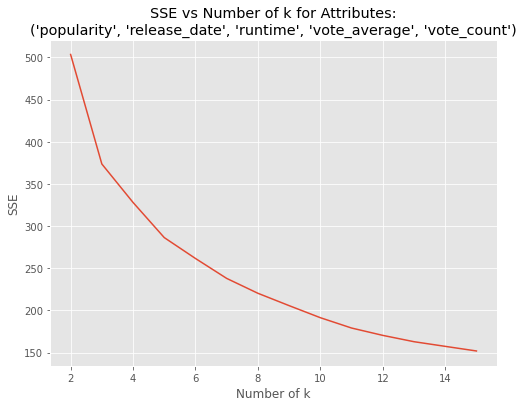

In [12]:
selected_attributes = ("popularity", "release_date", "runtime", "vote_average", "vote_count")
k = np.arange(2, 16)
kmeans_elbow_method(movies_ohe_df, columns=selected_attributes, cluster_numbers=k)

From the graph above, we can say that the optimal number of k is 5. Now, let's fit k-means clustering algorithm with k = 5 and see the results.

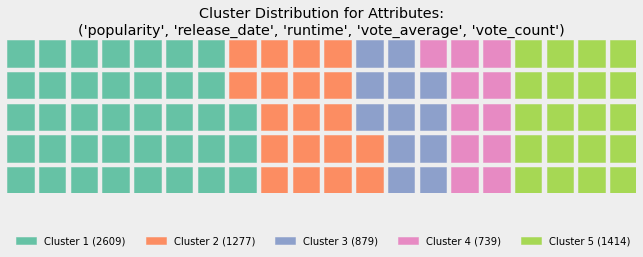

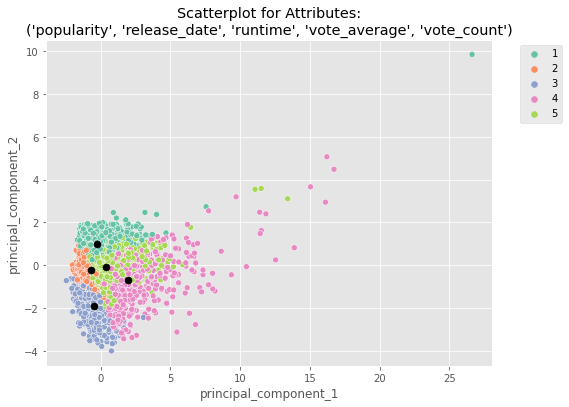

popularity release_date     runtime vote_average   vote_count
Cluster 1   8.250428  2007.190111  102.837869     6.320008   435.971637
Cluster 2   6.233352  1979.039937  105.596711      6.44863   127.640564
Cluster 3   6.110491  1953.781818  103.628409     7.170455   165.404545
Cluster 4   14.91801  1998.848444  143.859269     7.201083  1686.305819
Cluster 5    8.82084  2005.377652    101.1471     7.191796   623.991513

In [13]:
# selected_attributes = ("popularity", "release_date", "runtime", "vote_average", "vote_count")
cluster_result, cluster_labels = kmeans_clustering_pipeline(movies_ohe_df, columns=selected_attributes,
                                                            cluster_numbers=5)
cluster_result

Since we fit k-means algorithm with 5 attributes, so we performed Principal Component Analysis to transform them into 2 principal components before visualizing them on a scatterplot. According to the scatterplot, we can see that it's quite a clean split although there are some overlapping and outliers. In addition, based on the waffleplot, we can say that the distribution of 5 clusters are quite good, all clusters have reasonable number of movies which range from 739 to 2609. However, it's quite hard to interpret the clusters because some clusters have similar centroid values. For example, movies in Clusters 1, 2, 3 and 5 have similar runtime value about 102 minutes, only movies in Cluster 4 has longer runtime value which is 144 minutes on average. So, in the next combination, we will drop the attribute runtime.

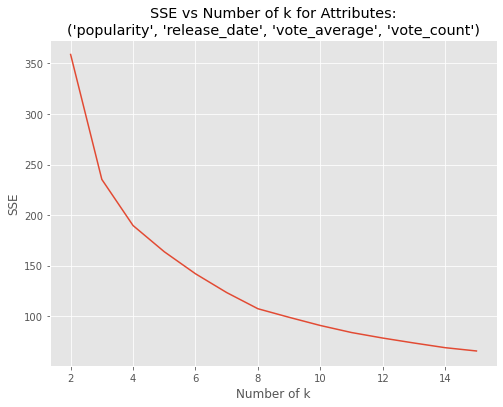

In [14]:
selected_attributes = ("popularity", "release_date", "vote_average", "vote_count")
k = np.arange(2, 16)
kmeans_elbow_method(movies_ohe_df, columns=selected_attributes, cluster_numbers=k)

From the graph above, we can say that the optimal number of k is 4. Now, let's fit k-means clustering algorithm with k = 4 and see the results.

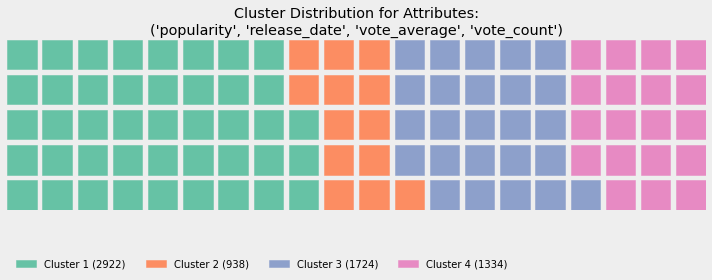

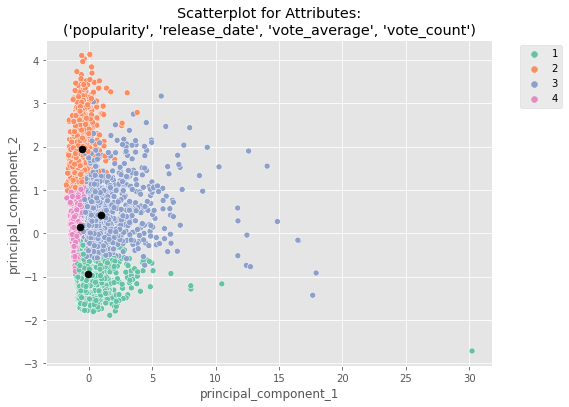

popularity release_date vote_average   vote_count
Cluster 1   8.469778  2007.146133     6.363347   470.393566
Cluster 2   6.304832   1954.84984     7.183387   178.759318
Cluster 3  11.243515  2004.198956     7.289153  1080.577146
Cluster 4   6.227075  1979.272864     6.461169   126.871814

In [15]:
# selected_attributes = ("popularity", "release_date", "vote_average", "vote_count")
cluster_result, cluster_labels = kmeans_clustering_pipeline(movies_ohe_df, columns=selected_attributes,
                                                            cluster_numbers=4)
cluster_result

Again, we can say that the distribution of 4 clusters are good based on the waffleplot which range from 938 to 2922. And it has a better split according to the scatterplot. The results also become more interpretable. Since we filtered our movies to have high rating which is being rated at least 6 out of 10, we can say that all of the movies are of high ratings. So, in the next combination, we will try to drop the attribute vote_average to see if the result will be better or not.

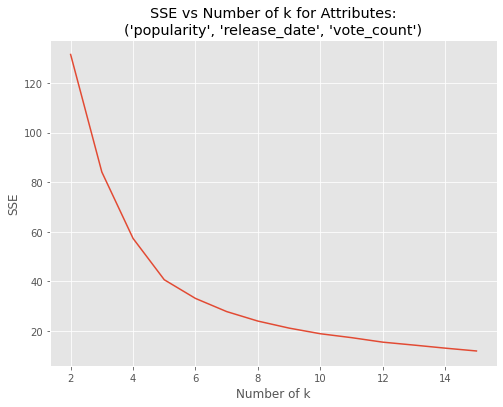

In [16]:
selected_attributes = ("popularity", "release_date", "vote_count")
k = np.arange(2, 16)
kmeans_elbow_method(movies_ohe_df, columns=selected_attributes, cluster_numbers=k)

From the graph above, we can say that the optimal number of k is 4. Now, let's fit k-means clustering algorithm with k = 4 and see the results.

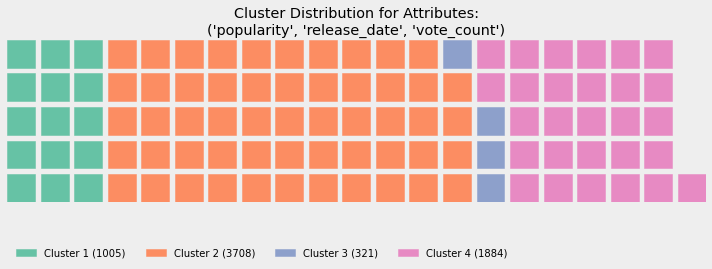

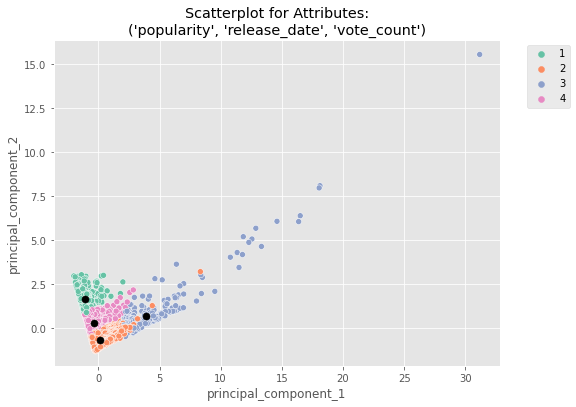

popularity release_date   vote_count
Cluster 1   5.752197  1953.311443   127.316418
Cluster 2   7.848705  2008.287756   398.192826
Cluster 3  30.286027  2007.857143  4640.872671
Cluster 4   7.284294  1984.997346   252.491507

In [17]:
# selected_attributes = ("popularity", "release_date", "vote_count")
cluster_result, cluster_labels = kmeans_clustering_pipeline(movies_ohe_df, columns=selected_attributes,
                                                            cluster_numbers=4)
cluster_result

Based on the waffleplot, it shows that the clusters are not evenly distributed. The smallest cluster has 321 movies but the largest cluster has 3708 movies. According to the scatterplot, it has a clean split as well. The good thing is the result becomes very interesting. Although Cluster 3 contains only 321 movies, all movies are recently released, very popular and received a lot of vote count. Cluster 1 contains very old movies, all movies are released on the year of 1953 on average, having rating at least 6 and above, but not gaining much attentions from the users. The other two clusters represent good movies with medium popularity and vote count, but one represents recently released movies, another one represents relatively old movies.

After running k-means clustering algorithm on three different combination of numerical attributes, we select the third clustering model as our best model because the results are more interpretable and more interesting. The seleced numerical attributes are as follow:
* popularity
* release_date
* vote_count

The final parameters for the k-means clustering are as follow:
* n_clusters = 4
* random_state = 0

## Agglomerative Clustering<a id=numerical_agglomerative><a>

To perform agglomerative clustering analysis on numerical attributes, let's define some functions specifically for agglomerative clustering.

In [18]:
def hierarchical_dendrogram(full_df, columns, linkage, affinity):
    """Use dendrogram to determine the best number of cluster for agglomerative clustering.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
        linkage (str): String specifying the linkage method such as single, complete or average
        affinity (str): String specifying the affinity such as euclidean or cityblock (manhattan)
    
    Display:
        Dendrogram: Dendrogram showing hierarchical clustering results
    """
    
    selected_df = select_attribute(full_df, columns)
    scaled_selected_df = min_max_scale(selected_df)
    plt.figure(figsize=(20,10))
    dend = sch.dendrogram(sch.linkage(scaled_selected_df, method=linkage, metric=affinity))
    plt.title("Dendrogram for Attributes:\n{}".format(columns))
    plt.show()

In [19]:
def agglomerative_clustering_pipeline(full_df, columns, cluster_numbers, linkage, affinity):
    """Pipeline to perform agglomerative clustering on selected attributes.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
        cluster_numbers (int): Number of cluster to obtain
        linkage (str): String specifying the linkage method such as single, complete or average
        affinity (str): String specifying the affinity such as euclidean or manhattan (cityblock)
    
    Display:
        Waffleplot: Waffleplot showing the distribution of clusters
        Scatterplot: Scatterplot of different clusters
        
    Returns:
        DataFrame: DataFrame consisting centroids of selected attributes for each cluster
        ndarray: Array consisting cluster labels
    """
    
    selected_df = select_attribute(full_df, columns)
    scaled_selected_df = min_max_scale(selected_df)
    ag = AgglomerativeClustering(n_clusters=cluster_numbers, linkage=linkage, affinity=affinity)
    ag.fit(scaled_selected_df)
    selected_df.insert(loc=selected_df.shape[1], column="Cluster", value=ag.labels_ + 1)
    centroid_df = cluster_centroid_original(selected_df)
    cluster_waffleplot(ag.labels_ + 1, columns)
    if len(columns) == 2:
        cluster_scatterplot(selected_df, centroid_df, columns)     
    else:
        standardized_df = standardization(selected_df.loc[:, selected_df.columns[:-1]])
        pca_df = pca(standardized_df, component_numbers=2)
        pca_df.insert(loc=pca_df.shape[1], column="Cluster", value=ag.labels_ + 1)
        pca_centroid_df = cluster_centroid_original(pca_df)
        cluster_scatterplot(pca_df, pca_centroid_df, columns)
    
    return centroid_df, ag.labels_ + 1

Now, let's proceed with the first numerical combination (popularity, release_date, runtime, vote_average, vote_count). We will find the best number of cluster for this combination using dendrogram. We will first set linkage to single and affinity to euclidean and see the result.

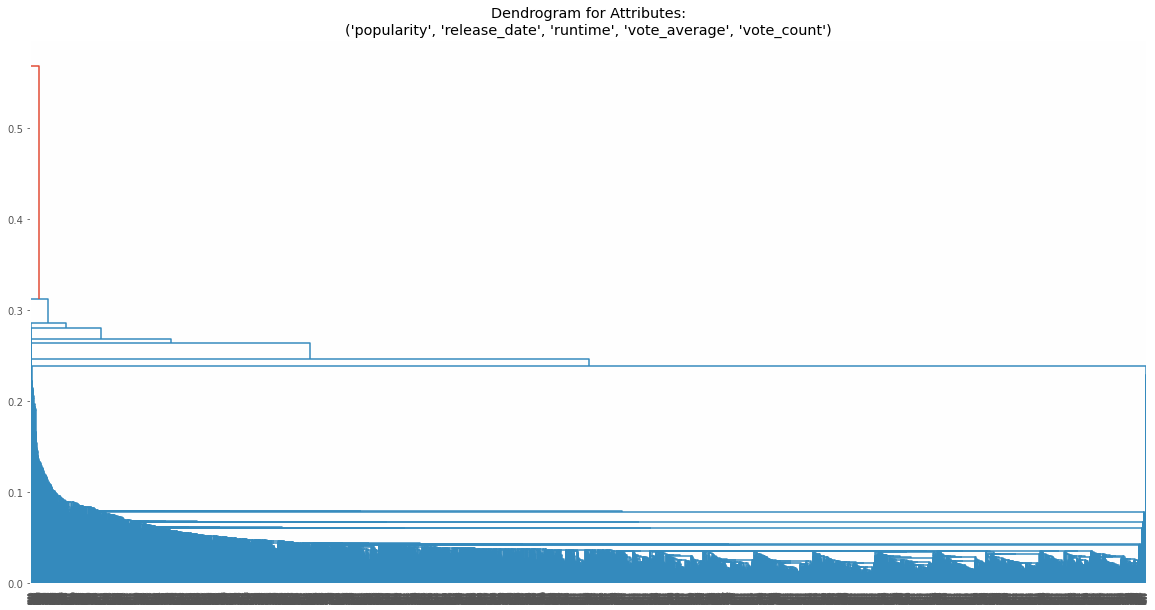

In [20]:
selected_attributes = ("popularity", "release_date", "runtime", "vote_average", "vote_count")
hierarchical_dendrogram(movies_ohe_df, columns=selected_attributes, linkage="single", affinity="euclidean")

By setting linkage to single, the result is terrible, so let's try to set the linkage to average.

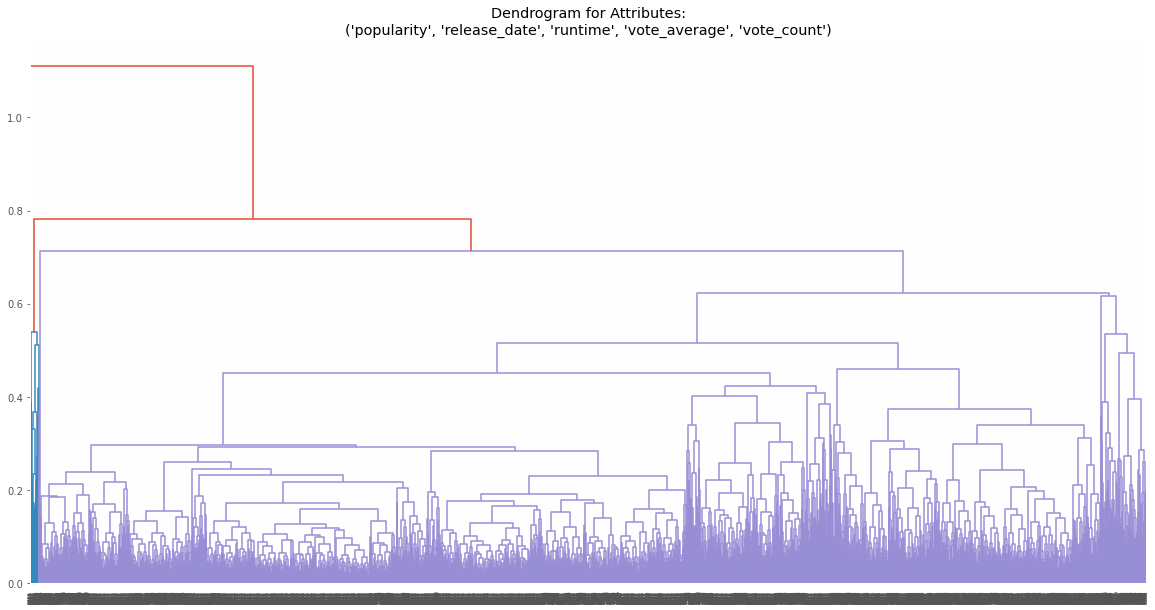

In [21]:
# selected_attributes = ("popularity", "release_date", "runtime", "vote_average", "vote_count")
hierarchical_dendrogram(movies_ohe_df, columns=selected_attributes, linkage="average", affinity="euclidean")

By setting linkage to average, it does not help much, the result is still terrible, so let's try to set the linkage to complete.

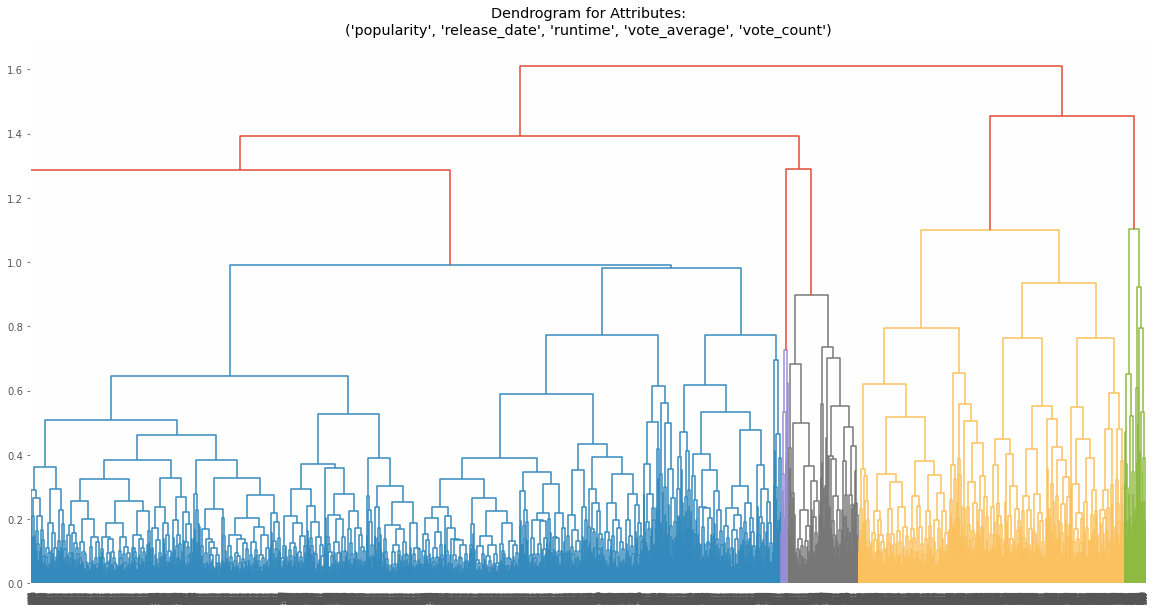

In [22]:
# selected_attributes = ("popularity", "release_date", "runtime", "vote_average", "vote_count")
hierarchical_dendrogram(movies_ohe_df, columns=selected_attributes, linkage="complete", affinity="euclidean")

By setting linkage to complete, the result seem much better. Let's try to set the affinity to cityblock (manhattan), see if the results will be better or not.

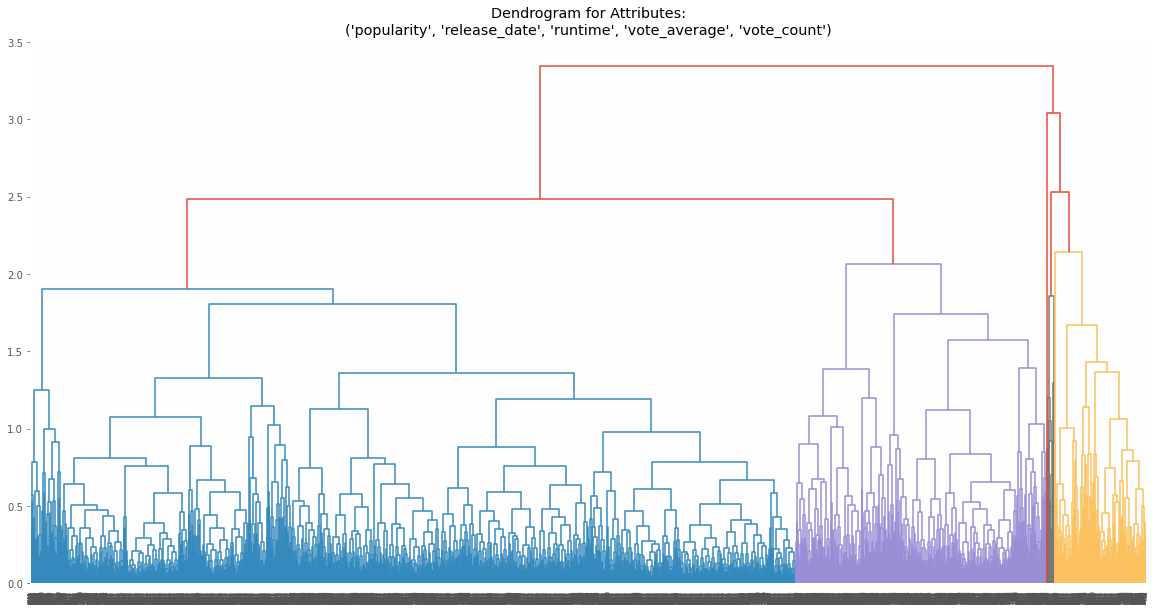

In [23]:
# selected_attributes = ("popularity", "release_date", "runtime", "vote_average", "vote_count")
hierarchical_dendrogram(movies_ohe_df, columns=selected_attributes, linkage="complete", affinity="cityblock")

By setting affinity to cityblock (manhattan), the result seems better because the distance between two clusters are much bigger. So, we will stick with these parameters while running other combination of numerical attributes. By looking at the dendrogram above, we can say that the optimal number of cluster for this combination is 2. Now, let's fit agglomerative clustering algorithm with n_clusters = 2 and see the results.

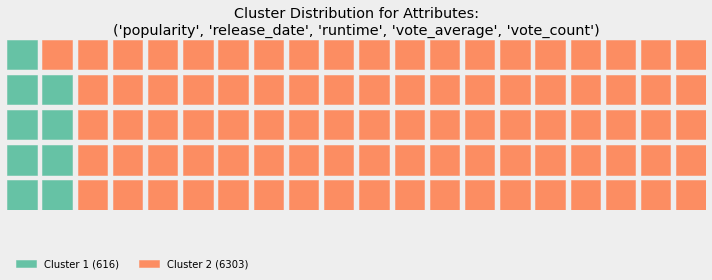

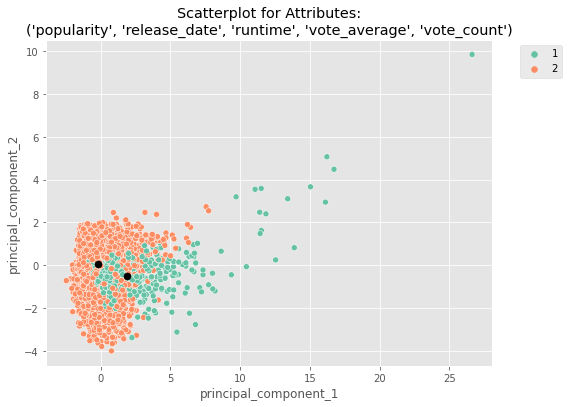

popularity release_date     runtime vote_average   vote_count
Cluster 1   16.87658      2004.25  113.670455     7.581494  1789.537338
Cluster 2   7.609661  1992.932889  106.878788     6.640393   392.218309

In [24]:
# selected_attributes = ("popularity", "release_date", "runtime", "vote_average", "vote_count")
cluster_result, cluster_labels = agglomerative_clustering_pipeline(movies_ohe_df, columns=selected_attributes,
                                                                   cluster_numbers=2, linkage="complete",
                                                                   affinity="manhattan")
cluster_result

Since we fit agglomerative algorithm with 5 attributes, so we performed Principal Component Analysis to transform them into 2 principal components before visualizing them on a scatterplot. According to the scatterplot, we can see that it's not a clean split. Based on the waffleplot, we can say that the distribution of 2 clusters are very uneven, Cluster 1 has only 616 movies but Cluster 2 has 6303 movies. To interpret the clusters, we calculated the centroid of each attribute, and found out that the result is quite interpretable. For Cluster 1, the movies are released recently, having longer runtime, higher popularity, ratings and vote count. For Cluster 2, the movies are released relatively earlier, having shorter runtime, lower popularity, ratings and vote count. However, it's not really a clean split, so we will try to drop the attribute runtime in the next combination

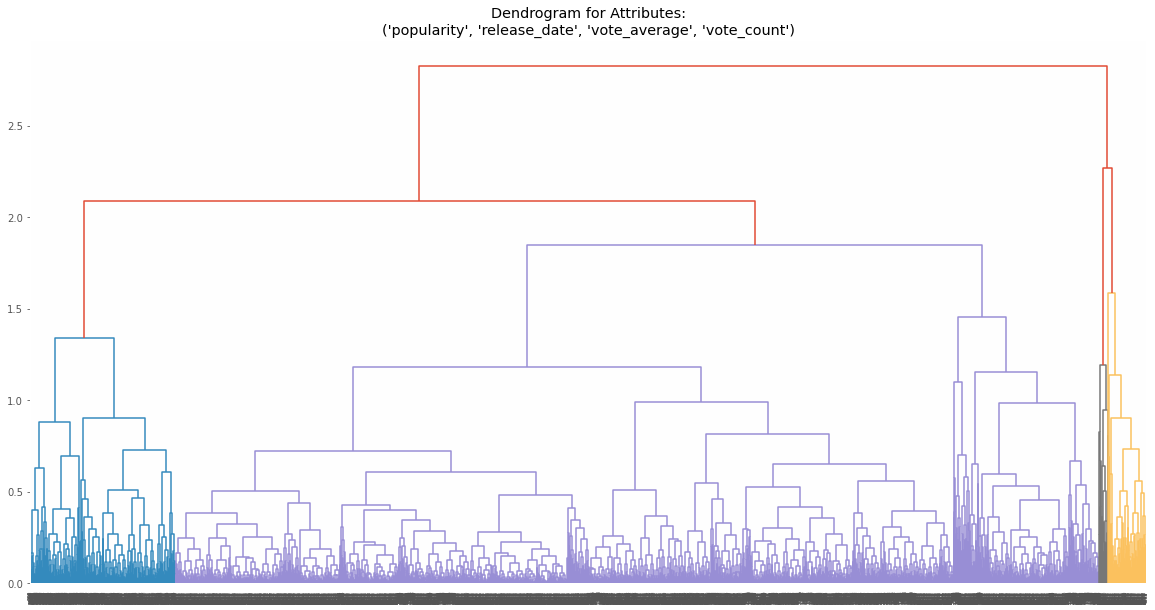

In [25]:
selected_attributes = ("popularity", "release_date", "vote_average", "vote_count")
hierarchical_dendrogram(movies_ohe_df, columns=selected_attributes, linkage="complete", affinity="cityblock")

By looking at the dendrogram above, we want to try cluster number of 4. Now, let's fit agglomerative clustering algorithm with n_clusters = 4 and see the results.

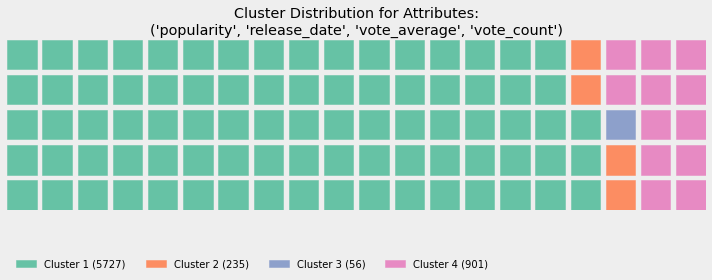

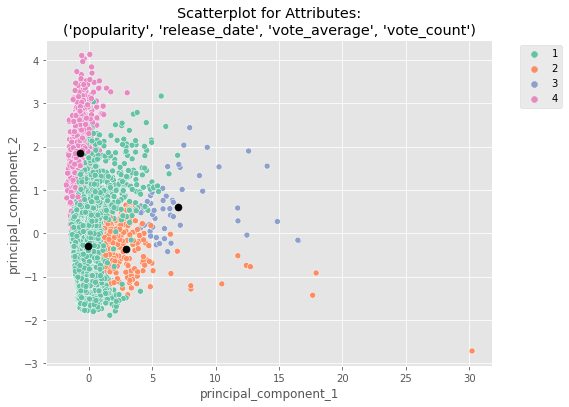

popularity release_date vote_average   vote_count
Cluster 1   7.735503  1999.690239     6.658652   393.234678
Cluster 2  25.957528  2010.846809     6.874894  3309.348936
Cluster 3  48.265469  2009.089286     7.541071  7652.053571
Cluster 4   5.833028  1952.042175      7.05061   129.012209

In [26]:
# selected_attributes = ("popularity", "release_date", "vote_average", "vote_count")
cluster_result, cluster_labels = agglomerative_clustering_pipeline(movies_ohe_df, columns=selected_attributes,
                                                                   cluster_numbers=4, linkage="complete",
                                                                   affinity="manhattan")
cluster_result

Again, we can say that the distribution of 4 clusters are very uneven based on the waffleplot which range from 56 to 5727. However, this time it has a clean split according to the scatterplot. And the results are still very interpretable, but the problem is the smallest cluster only contains 56 movies, which is very insufficient. Since we filtered our movies to have high rating which is being rated at least 6 out of 10, we can say that all of the movies are of high ratings. So, in the next combination, we will try to drop the attribute vote_average to see if the result will be better or not.

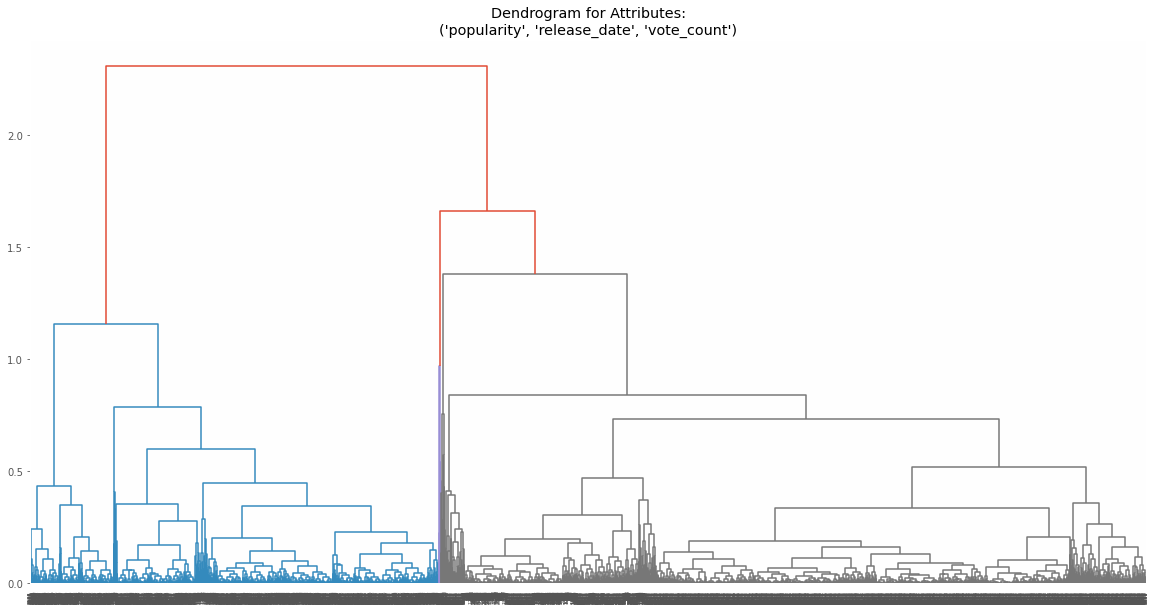

In [27]:
selected_attributes = ("popularity", "release_date", "vote_count")
hierarchical_dendrogram(movies_ohe_df, columns=selected_attributes, linkage="complete", affinity="cityblock")

By looking at the dendrogram above, we can see that the optimum number of cluster is 2. Now, let's fit agglomerative clustering algorithm with n_clusters = 2 and see the results.

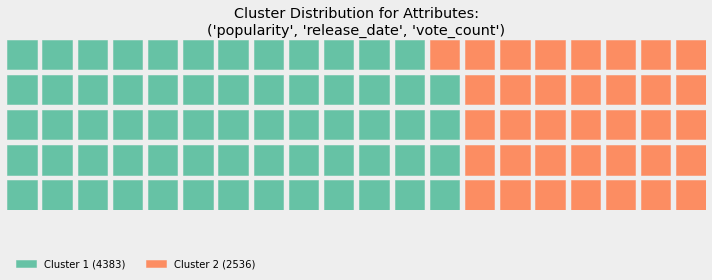

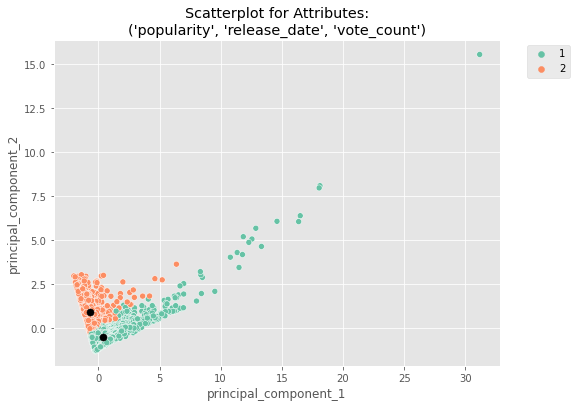

popularity release_date  vote_count
Cluster 1   9.486633  2007.170888  698.702259
Cluster 2   6.616622  1971.074132  201.930205

In [28]:
# selected_attributes = ("popularity", "release_date", "vote_count")
cluster_result, cluster_labels = agglomerative_clustering_pipeline(movies_ohe_df, columns=selected_attributes,
                                                                   cluster_numbers=2, linkage="complete",
                                                                   affinity="manhattan")
cluster_result

Based on the waffleplot, it shows that the clusters are evenly distributed which range from 2536 to 4383. According to the scatterplot, it has a clean split as well. And the results are very interpretable but it's not as interesting as second agglomerative clustering model. Cluster 1 represents the movies that released recently, having high popularity, vote count and ratings. Cluster 2 represents the old movies with high ratings, but not gaining much attention by the users.

After running agglomerative clustering algorithm on three different combination of numerical attributes, we select the third clustering model as our best model because the results are interpretable and have sufficient movies for each cluster. The seleced numerical attributes are as follow:
* popularity
* release_date
* vote_count

The final parameters for the agglomerative clustering are as follow:
* n_clusters = 2
* linkage = complete
* affinity = manhattan

## Best Clustering Model<a id=numerical_best><a>

We select k-means as the best clustering model for numerical attributes because the final model produces more clusters, and the results are more interesting, and able to recommend more relevant movies to the users. The result of best clustering model for numerical attributes are as follow.

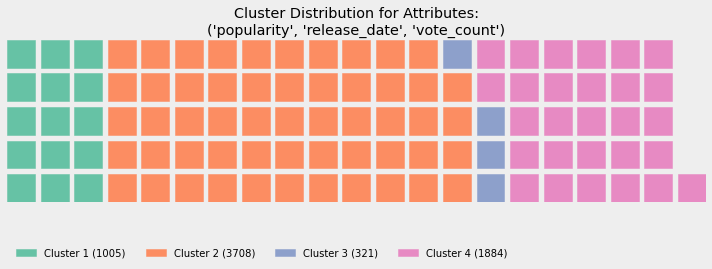

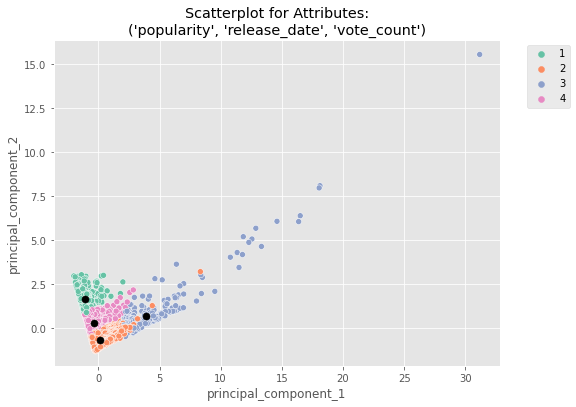

popularity release_date   vote_count
Cluster 1   5.752197  1953.311443   127.316418
Cluster 2   7.848705  2008.287756   398.192826
Cluster 3  30.286027  2007.857143  4640.872671
Cluster 4   7.284294  1984.997346   252.491507

In [29]:
selected_attributes = ("popularity", "release_date", "vote_count")
cluster_result, cluster_labels = kmeans_clustering_pipeline(movies_ohe_df, columns=selected_attributes,
                                                            cluster_numbers=4)
cluster_result

To recap, the interpretation of the best clustering model for numerical attributes are as follow:
* Cluster 1 - Extremely old but high rating movies 
* Cluster 2 - Popular movies
* Cluster 3 - Extremely popular movies
* Cluster 4 - Old but popular movies

The selected numerical attributes are as follow:
* popularity
* release_date
* vote_count

The final parameters for the k-means clustering are as follow:
* n_clusters = 4
* random_state = 0

Now let's look at some example of movies from each cluster. Before that, let's define a function to do that.

In [30]:
def view_cluster_examples(full_df, cluster_labels, cluster_to_view):
    """View some examples of a cluster.
    
    Paramaters:
        full_df (DataFrame): DataFrame consisting all attributes
        cluster_labels (ndarray): Array consisting cluster labels
        cluster_to_view (int): Number of cluster to view
    
    Return:
        DataFrame: DataFrame consisting 5 examples in the selected cluster
    """
    
    selected_df = full_df.copy()
    selected_df.insert(loc=selected_df.shape[1], column="Cluster" , value=cluster_labels)
    
    return selected_df.loc[selected_df["Cluster"] == cluster_to_view, :].sample(5)

In [31]:
# Cluster 1 - Extremely old but high rating movies 
movies_df = pd.read_csv("movies_metadata_cleaned.csv", parse_dates=['release_date'])
movies_df.loc[:, "release_date"] = movies_df['release_date'].dt.year
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=1)

belongs_to_collection                          genres    id  \
1450  To Sir, with Love Collection                       ['Drama']  3296   
2136                           NaN              ['Crime', 'Drama']  4998   
794                            NaN    ['Drama', 'Comedy', 'Music']  1937   
1478                           NaN               ['War', 'Action']  3367   
1565                           NaN  ['Comedy', 'Music', 'Romance']  3549   

      popularity                               production_companies  \
1450    8.138554                   ['Columbia British Productions']   
2136    3.666979  ['Stanley Kramer Productions', 'Curtleigh Prod...   
794     5.682778                             ['Paramount Pictures']   
1478    3.007031                                ['Wolper Pictures']   
1565    4.860664                    ['Samuel Goldwyn Company, The']   

      release_date  runtime                title  vote_average  vote_count  \
1450          1967    105.0    To Sir, with Love           7.6        72.0   
2136          1958     96.0     The Defiant Ones           6.9        49.0   
794           1944    130.0         Going My Way           6.9        37.0   
1478          1968    130.0  The Devil's Brigade           6.4        23.0   
1565          1955    150.0       Guys and Dolls           6.9        55.0   

                     directors  \
1450         ['James Clavell']   
2136        ['Stanley Kramer']   
794            ['Leo McCarey']   
1478    ['Andrew V. McLaglen']   
1565  ['Joseph L. Mankiewicz']   

                                             characters  Cluster  
1450  ['Sidney Poitier', 'Suzy Kendall', 'Christian ...        1  
2136  ['Tony Curtis', 'Sidney Poitier', 'Theodore Bi...        1  
794   ['Bing Crosby', 'Barry Fitzgerald', 'Frank McH...        1  
1478  ['William Holden', 'Cliff Robertson', 'Vince E...        1  
1565  ['Marlon Brando', 'Jean Simmons', 'Frank Sinat...        1

In [32]:
# Cluster 2 - Popular movies
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=2)

belongs_to_collection                    genres      id  popularity  \
3462                   NaN    ['Action', 'Thriller']   26989    2.919575   
4537                   NaN                ['Comedy']   69069    6.312206   
1843                   NaN     ['Drama', 'Thriller']    4234    6.226933   
6288                   NaN  ['Drama', 'Documentary']  139525    4.889765   
5656                   NaN    ['Action', 'Thriller']  107675    3.587006   

                                   production_companies  release_date  \
3462  ['Lolafilms', 'Instituto Mexicano de Cinematog...          1997   
4537  ['Screen Gems', 'Moving Pictures, DPI', 'Weins...          2009   
1843              ['Columbia Pictures', 'Merlin Films']          2001   
6288     ['The Documentary Group', 'Our Time Projects']          2015   
5656                                ['Richwater Films']          2013   

      runtime                 title  vote_average  vote_count  \
3462    126.0  Dance with the Devil           6.2        39.0   
4537     90.0             Fired Up!           6.0       194.0   
1843    109.0  The Tailor of Panama           6.2        97.0   
6288    100.0           Cartel Land           7.4       160.0   
5656    102.0              Vendetta           6.1        27.0   

                   directors  \
3462  ['Álex de la Iglesia']   
4537          ['Will Gluck']   
1843        ['John Boorman']   
6288    ['Matthew Heineman']   
5656    ['Stephen Reynolds']   

                                             characters  Cluster  
3462   ['Rosie Perez', 'Javier Bardem', 'Harley Cross']        2  
4537  ["Nicholas D'Agosto", 'Eric Christian Olsen', ...        2  
1843  ['Pierce Brosnan', 'Geoffrey Rush', 'Jamie Lee...        2  
6288  ['Robert Hetrick', 'José Manuel Mireles Valver...        2  
5656   ['Danny Dyer', 'Roxanne McKee', 'Vincent Regan']        2

In [33]:
# Cluster 3 - Extremely popular movies
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=3)

belongs_to_collection                                      genres  \
5611                         NaN                        ['Drama', 'History']   
4293         Iron Man Collection  ['Action', 'Science Fiction', 'Adventure']   
5147  The Expendables Collection         ['Action', 'Adventure', 'Thriller']   
1141        Star Wars Collection  ['Adventure', 'Action', 'Science Fiction']   
1203                         NaN            ['Mystery', 'Thriller', 'Drama']   

          id  popularity                               production_companies  \
5611  106100   14.785719  ['Universal Studios', 'Universal Pictures', 'V...   
4293   59315   22.073099           ['Paramount Pictures', 'Marvel Studios']   
5147   91485   14.881566             ['Nu Image Films', 'Millennium Films']   
1141    2628   15.649091                                      ['Lucasfilm']   
1203    2762   18.449169  ['Spyglass Entertainment', 'The Kennedy/Marsha...   

      release_date  runtime                                      title  \
5611          2013    117.0                         Dallas Buyers Club   
4293          2008    126.0                                   Iron Man   
5147          2012    103.0                          The Expendables 2   
1141          1999    136.0  Star Wars: Episode I - The Phantom Menace   
1203          1999    107.0                            The Sixth Sense   

      vote_average  vote_count               directors  \
5611           7.9      2973.0    ['Jean-Marc Vallée']   
4293           7.4      8951.0         ['Jon Favreau']   
5147           6.1      2940.0          ['Simon West']   
1141           6.4      4526.0        ['George Lucas']   
1203           7.7      3223.0  ['M. Night Shyamalan']   

                                             characters  Cluster  
5611  ['Matthew McConaughey', 'Jennifer Garner', 'Ja...        3  
4293  ['Robert Downey Jr.', 'Terrence Howard', 'Jeff...        3  
5147  ['Sylvester Stallone', 'Jason Statham', 'Dolph...        3  
1141  ['Liam Neeson', 'Ewan McGregor', 'Natalie Port...        3  
1203  ['Bruce Willis', 'Toni Collette', 'Olivia Will...        3

In [34]:
# Cluster 4 - Old but popular movies
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=4)

belongs_to_collection                genres     id  popularity  \
1685                   NaN             ['Drama']   3813    4.515797   
3188                   NaN  ['Drama', 'Romance']   8838    4.195988   
2699                   NaN             ['Drama']   6832    6.972737   
3438                   NaN  ['Drama', 'Fantasy']  26749    1.572239   
1368                   NaN   ['Drama', 'Family']   3111    3.712567   

                               production_companies  release_date  runtime  \
1685                             ['United Artists']          1978     93.0   
3188                               ['Warner Bros.']          1974    112.0   
2699                         ['Paramount Pictures']          1991    108.0   
3438                                    ['Allarts']          1991    120.0   
1368  ['TriStar Pictures', 'Delphi II Productions']          1984    111.0   

                                title  vote_average  vote_count  \
1685                        Interiors           6.7        92.0   
3188  Alice Doesn't Live Here Anymore           6.7        83.0   
2699                  Regarding Henry           6.6       152.0   
3438                 Prospero's Books           6.5        27.0   
1368              Places in the Heart           7.1        31.0   

                directors                                         characters  \
1685      ['Woody Allen']  ['Diane Keaton', 'Kristin Griffith', 'Mary Bet...   
3188  ['Martin Scorsese']  ['Ellen Burstyn', 'Kris Kristofferson', 'Alfre...   
2699     ['Mike Nichols']   ['Harrison Ford', 'Annette Bening', 'Bill Nunn']   
3438  ['Peter Greenaway']  ['John Gielgud', 'Michael Clark', 'Michel Blanc']   
1368    ['Robert Benton']  ['Sally Field', 'Lindsay Crouse', 'John Malkov...   

      Cluster  
1685        4  
3188        4  
2699        4  
3438        4  
1368        4

## Recommend Nearest Neighbors<a id=numerical_neighbors><a>

To recommend the nearest neighbors in the same cluster to the users based on their watching history, we need to calculate the euclidean distance of the movie being watched with all the other movies based on the attributes that we selected namely popularity, release_date and vote_count. To accomplish that, let's define a function for it.

In [35]:
def nearest_neighbors_euclidean(full_df, cluster_labels, selected_movie_id):
    """Use euclidean distance to find out the nearest neighbors within the same cluster.
    
    Paramaters:
        full_df (DataFrame): DataFrame consisting all attributes
        cluster_labels (ndarray): Array consisting cluster labels
        selected_movie_id (int): Movie ID being watched
    
    Return:
        DataFrame: DataFrame consisting 5 nearest neighbors
    """

    selected_df = full_df.copy()
    selected_attributes = ["popularity", "release_date", "vote_count"]
    selected_df.insert(loc=selected_df.shape[1], column="Cluster" , value=cluster_labels)
    selected_cluster = int(selected_df.loc[selected_df["id"] == selected_movie_id, "Cluster"])
    selected_df = selected_df.loc[selected_df["Cluster"] == selected_cluster, :]
    selected_movie = selected_df.loc[selected_df["id"] == selected_movie_id, :]
    euclidean_dist = np.linalg.norm(selected_df[selected_attributes].values
                                    - selected_movie[selected_attributes].values, axis=1)
    selected_df.insert(loc=selected_df.shape[1], column="Euclidean Distance", value=euclidean_dist)
    nearest_neighbors_df = selected_df.sort_values("Euclidean Distance").head(6)[1:]
    
    return nearest_neighbors_df

Now, let's try the nearest_neighbors_euclidean function with the movie "Guardians of the Galaxy". The details of the movie are as follow:
* id = 112852
* title = Guardians of the Galaxy
* popularity = 53.291601
* release_date = 2014
* vote_count = 10014

In [36]:
nearest_neighbors_euclidean(movies_df, cluster_labels, selected_movie_id=112852)

belongs_to_collection  \
5373                          NaN   
1292                          NaN   
5148  The Hunger Games Collection   
6022           Mad Max Collection   
5149   The Dark Knight Collection   

                                                 genres      id  popularity  \
5373                               ['Drama', 'Western']   99114   19.785025   
1292                                          ['Drama']    2959   63.869599   
5148        ['Science Fiction', 'Adventure', 'Fantasy']   91500   20.031667   
6022  ['Action', 'Adventure', 'Science Fiction', 'Th...  122882   29.361780   
5149           ['Action', 'Crime', 'Drama', 'Thriller']   91529   20.582580   

                                   production_companies  release_date  \
5373     ['Columbia Pictures', 'The Weinstein Company']          2012   
1292  ['Twentieth Century Fox Film Corporation', 'Re...          1999   
5148                       ['Lionsgate', 'Color Force']          2012   
6022  ['Village Roadshow Pictures', 'Kennedy Miller ...          2015   
5149  ['Legendary Pictures', 'Warner Bros.', 'DC Ent...          2012   

      runtime                  title  vote_average  vote_count  \
5373    165.0       Django Unchained           7.8     10297.0   
1292    139.0             Fight Club           8.3      9678.0   
5148    142.0       The Hunger Games           6.9      9634.0   
6022    120.0     Mad Max: Fury Road           7.3      9629.0   
5149    165.0  The Dark Knight Rises           7.6      9263.0   

                  directors  \
5373  ['Quentin Tarantino']   
1292      ['David Fincher']   
5148          ['Gary Ross']   
6022      ['George Miller']   
5149  ['Christopher Nolan']   

                                             characters  Cluster  \
5373  ['Jamie Foxx', 'Christoph Waltz', 'Leonardo Di...        3   
1292        ['Edward Norton', 'Brad Pitt', 'Meat Loaf']        3   
5148  ['Jennifer Lawrence', 'Josh Hutcherson', 'Liam...        3   
6022  ['Tom Hardy', 'Charlize Theron', 'Nicholas Hou...        3   
5149  ['Christian Bale', 'Michael Caine', 'Gary Oldm...        3   

      Euclidean Distance  
5373          284.983667  
1292          336.500957  
5148          381.458023  
6022          385.744263  
5149          751.714627

The 5 nearest neighbors appeared as expected!

# B. Clustering Analysis on Categorical Attributes<a id=categorical><a>

First, let's import all the necessary libraries for clustering analysis on categorical attributes.

In [37]:
# Libraries for data manipulation
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from pywaffle import Waffle
from wordcloud import WordCloud

# Libraries for clustering analysis
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

Let's have a look at the movies metadata again.

In [38]:
movies_ohe_df = pd.read_csv("movies_metadata_ohe.csv", parse_dates=['release_date'])
movies_ohe_df.loc[:, "release_date"] = movies_ohe_df['release_date'].dt.year
print(movies_ohe_df.shape)
movies_ohe_df.head()

(6919, 992)


id  popularity  release_date  runtime              title  vote_average  \
0   1   21.946943          1995     81.0          Toy Story           7.7   
1   2   17.015539          1995    104.0            Jumanji           6.9   
2   3   11.712900          1995    101.0   Grumpier Old Men           6.5   
3   4    3.859495          1995    127.0  Waiting to Exhale           6.1   
4   6   17.924927          1995    170.0               Heat           7.7   

   vote_count  28 Days/Weeks Later Collection  300 Collection  \
0      5415.0                               0               0   
1      2413.0                               0               0   
2        92.0                               0               0   
3        34.0                               0               0   
4      1886.0                               0               0   

   A Better Tomorrow Collection  ...  Will Smith  Willem Dafoe  \
0                             0  ...           0             0   
1                             0  ...           0             0   
2                             0  ...           0             0   
3                             0  ...           0             0   
4                             0  ...           0             0   

   William H. Macy  William Holden  William Hurt  Winona Ryder  Woody Allen.1  \
0                0               0             0             0              0   
1                0               0             0             0              0   
2                0               0             0             0              0   
3                0               0             0             0              0   
4                0               0             0             0              0   

   Woody Harrelson  Zac Efron  Zoe Saldana  
0                0          0            0  
1                0          0            0  
2                0          0            0  
3                0          0            0  
4                0          0            0  

[5 rows x 992 columns]

We noticed that there are 5 categorical attributes in the movies metadata namely collection, genre, company, director and character. We performed one hot encoding on all these categorical variables. We will perform clustering analysis on two combinations as follow:
* (collection, genre, company, director, character)
* (collection, genre, director, character)

Then, the best clustering model and combination will be selected. The best clustering model is selected based on the interpretability of the model. The main focus will be placed on the attribute genre because the other categorical attributes have too many categories, it is difficult to achieve a clean split for them. To perform clustering analysis on categorical attributes, let's define some general helper functions.

In [39]:
def select_attribute(full_df, columns):
    """Select subset of attributes.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
    
    Returns:
        DataFrame: DataFrame consisting subset of attributes only
    """

    if type(columns) != list:
        columns = list(columns)
    selected_df = full_df.loc[:, columns]
    
    return selected_df

In [40]:
def cluster_top_items(label_df, column_names):
    """Get the top items for each cluster.
    
    Parameters:
        label_df (DataFrame): DataFrame consisting selected attributes with cluster labels
        column_names (tuple): Tuple specifying the selected column names
    
    Returns:
        DataFrame: DataFrame consisting top items for each cluster
    """

    cluster_numbers = len(label_df["Cluster"].unique())
    all_items = {"collection": 275, "genre": 20, "company": 224, "director": 91, "character": 375}
    top_items = {}
    check = 0
    for i in range(1, cluster_numbers + 1):
        previous_index = 0
        for element in column_names:
            subset = label_df.loc[label_df["Cluster"] == i,
                                  label_df.columns[previous_index : previous_index + all_items[element]]]
            top3_index = list(subset.sum().sort_values(ascending=False).index[0:3])
            top3_value = list(subset.sum().sort_values(ascending=False).head(3))
            for j in range(3):
                top_value = round(top3_value[j] / sum(label_df[top3_index[j]]) * 100, 2)
                if check == 0:
                    top_items["top_{}_{}".format(j+1, element)] = ["{} ({}%)".format(top3_index[j], top_value)]
                else:
                    top_items["top_{}_{}".format(j+1, element)].append("{} ({}%)".format(top3_index[j], top_value))
            previous_index += all_items[element]
        check = 1
    top_items_df = pd.DataFrame(top_items, index=["Cluster {}".format(i + 1) for i in range(cluster_numbers)])
    
    return top_items_df

In [41]:
def cluster_waffleplot(cluster_labels, column_names):
    """Use waffleplot to visualize the distribution of clusters.
    
    Parameters:
        cluster_labels (ndarray): Array consisting cluster labels
        column_names (tuple): Tuple specifying the selected column names
    
    Display:
        Waffleplot: Waffleplot showing the distribution of clusters
    """
    
    cluster_numbers = len(set(cluster_labels))
    cluster = {}
    for i in range(cluster_numbers):
        cluster["Cluster {}".format(i + 1)] = sum(cluster_labels == i + 1) / len(cluster_labels) * 100
    plt.style.use("ggplot")
    legend_col = len(cluster)
    if len(cluster) > 5:
        legend_col = 5
    fig = plt.figure(FigureClass=Waffle, rows=5, values=cluster,
                     title={"label": "Cluster Distribution for Attributes:\n{}".format(column_names)},
                     labels=["{0} ({1})".format(k, int(v/100*len(cluster_labels))) for k, v in cluster.items()],
                     legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': legend_col,
                             'framealpha': 0}, figsize=(10,6))
    fig.gca().set_facecolor('#EEEEEE')
    fig.set_facecolor('#EEEEEE')
    plt.show()

In [42]:
def cluster_wordcloud(label_df):
    """Generate wordcloud to visualize the common items of each cluster.
    
    Parameters:
        label_df (DataFrame): DataFrame consisting selected attributes with cluster labels
    
    Display:
        Wordcloud: Wordcloud showing the common items of each cluster
    """
    
    cluster_numbers = len(label_df["Cluster"].unique())
    gs_row = cluster_numbers // 2
    if cluster_numbers % 2 != 0:
        gs_row = (cluster_numbers + 1) // 2
    gs = mpl.gridspec.GridSpec(nrows=gs_row, ncols=2)
    fig = plt.figure(figsize=(12,10))
    ax_row = 0
    ax_column = 0
    for i in range(1, cluster_numbers + 1):
        subset = label_df.loc[label_df["Cluster"] == i, label_df.columns[:-1]]
        subset = subset.loc[:, subset.sum() > 0]
        subset = pd.DataFrame(subset.sum()).reset_index()
        subset.columns = ["word", "count"]
        subset = subset.set_index("word").to_dict()["count"]
        ax = plt.subplot(gs[ax_row, ax_column])
        ax.set_title("Cluster {}".format(i))
        wordcloud = WordCloud(width=900, height=500, max_words=2000, relative_scaling=0.5,
                              normalize_plurals=False, colormap="Blues").generate_from_frequencies(subset)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        ax_column += 1
        if ax_column > 1:
            ax_row += 1
            ax_column = 0
    plt.show()

## K-Modes Clustering<a id=categorical_kmodes><a>

To perform k-modes clustering analysis on categorical attributes, let's define some functions specifically for k-modes clustering.

In [43]:
def kmodes_elbow_method(full_df, columns, column_names, cluster_numbers):
    """Use elbow method to determine the best number of cluster for k-modes clustering.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
        column_names (tuple): Tuple specifying the selected column names
        cluster_numbers (list): List specifying the number of clusters to test
    
    Display:
        Lineplot: Lineplot showing cost vs number of k for selected attributes
    """
    
    selected_df = select_attribute(full_df, columns)
    cost = {"k": list(), "cost": list()}
    for k in cluster_numbers:
        km = KModes(n_clusters=k, init="Huang", n_init=5, random_state=0)
        km.fit(selected_df)
        cost["k"].append(k)
        cost["cost"].append(km.cost_)
    plt.style.use("ggplot")
    plt.figure(figsize=(8,6))
    plt.plot(cost["k"], cost["cost"])
    plt.title("Cost vs Number of k for Attributes:\n{}".format(column_names))
    plt.xlabel("Number of k")
    plt.ylabel("Cost")
    plt.show()

In [44]:
def kmodes_clustering_pipeline(full_df, columns, column_names, cluster_numbers):
    """Pipeline to perform k-modes clustering on selected attributes.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
        column_names (tuple): Tuple specifying the selected column names
        cluster_numbers (int): Number of cluster to obtain
    
    Display:
        Waffleplot: Waffleplot showing the distribution of clusters
        Wordcloud: Wordcloud showing the common items of each cluster
        
    Returns:
        DataFrame: DataFrame consisting top items for each cluster
        ndarray: Array consisting cluster labels
    """
  
    selected_df = select_attribute(full_df, columns)
    km = KModes(n_clusters=cluster_numbers, init="Huang", n_init=5, random_state=0)
    cluster_labels = km.fit_predict(selected_df)
    selected_df.insert(loc=selected_df.shape[1], column="Cluster", value=cluster_labels + 1)
    top_items_df = cluster_top_items(selected_df, column_names)
    cluster_waffleplot(cluster_labels + 1, column_names)
    cluster_wordcloud(selected_df)
    
    return top_items_df, cluster_labels + 1

Now, let's proceed with the first categorical combination (collection, genre, company, director, character). We will find the best number of cluster (k) for this combination using elbow method.

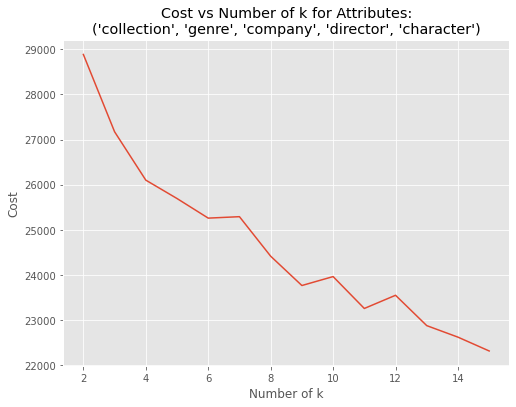

In [45]:
categorical_attributes = {"collection": list(movies_ohe_df.columns[7:282]),
                          "genre": list(movies_ohe_df.columns[282:302]),
                          "company": list(movies_ohe_df.columns[302:526]),
                          "director": list(movies_ohe_df.columns[526:617]),
                          "character": list(movies_ohe_df.columns[617:992])}
selected_attribute_names = ("collection", "genre", "company", "director", "character")
selected_attribute_columns = []
for element in selected_attribute_names:
    selected_attribute_columns.extend(categorical_attributes[element])
k = np.arange(2, 16)
kmodes_elbow_method(movies_ohe_df, columns=selected_attribute_columns, column_names=selected_attribute_names,
                    cluster_numbers=k)

From the graph above, we can say that the optimal number of k is 6. Now, let's fit k-modes clustering algorithm with k = 6 and see the results.

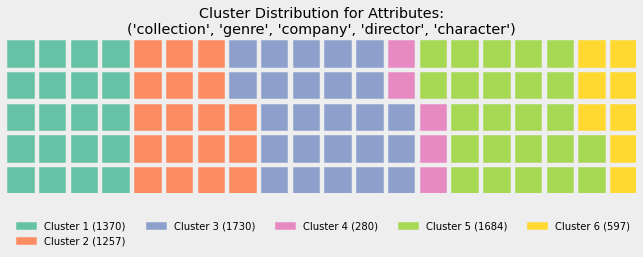

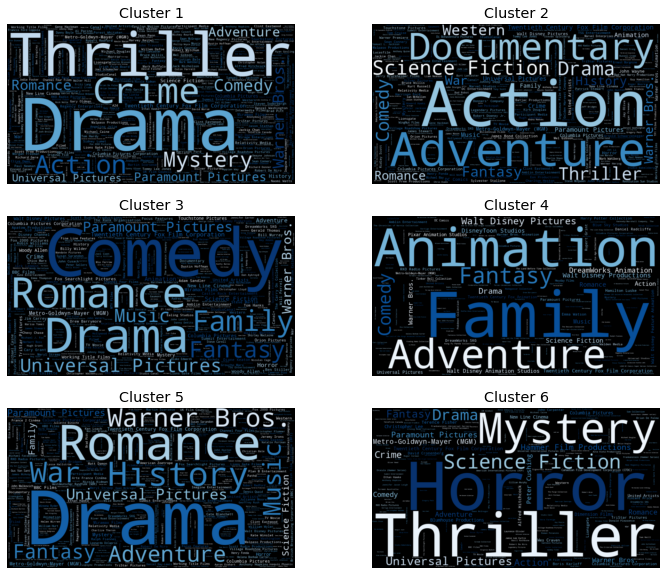

top_1_collection  \
Cluster 1  The Fast and the Furious Collection (87.5%)   
Cluster 2               James Bond Collection (95.24%)   
Cluster 3             The Carry On Collection (100.0%)   
Cluster 4             Harry Potter Collection (100.0%)   
Cluster 5                    Rocky Collection (100.0%)   
Cluster 6             Dracula (Hammer Series) (100.0%)   

                                          top_2_collection  \
Cluster 1                  Jesse Stone Collection (100.0%)   
Cluster 2                    Star Wars Collection (100.0%)   
Cluster 3  National Lampoon's Vacation Collection (100.0%)   
Cluster 4                  Tinker Bell Collection (100.0%)   
Cluster 5                       Step Up Collection (80.0%)   
Cluster 6            Frankenstein (Hammer Series) (100.0%)   

                          top_3_collection      top_1_genre  \
Cluster 1  Dirty Harry Collection (100.0%)   Drama (29.23%)   
Cluster 2        X-Men Collection (100.0%)  Action (64.45%)   
Cluster 3   The Muppet Collection (83.33%)  Comedy (80.62%)   
Cluster 4      Pokémon Collection (100.0%)  Family (44.14%)   
Cluster 5    Before... Collection (100.0%)   Drama (42.61%)   
Cluster 6          Saw Collection (100.0%)  Horror (72.02%)   

                  top_2_genre           top_3_genre  \
Cluster 1   Thriller (63.12%)        Crime (84.97%)   
Cluster 2  Adventure (46.93%)  Documentary (83.97%)   
Cluster 3      Drama (19.59%)      Romance (43.42%)   
Cluster 4  Animation (55.01%)    Adventure (22.57%)   
Cluster 5    Romance (38.25%)      History (54.37%)   
Cluster 6   Thriller (25.27%)      Mystery (30.94%)   

                           top_1_company  \
Cluster 1           Warner Bros. (29.0%)   
Cluster 2          Warner Bros. (19.26%)   
Cluster 3    Universal Pictures (30.15%)   
Cluster 4  Walt Disney Pictures (42.11%)   
Cluster 5          Warner Bros. (23.16%)   
Cluster 6    Universal Pictures (11.81%)   

                                             top_2_company  \
Cluster 1                      Paramount Pictures (22.16%)   
Cluster 2  Twentieth Century Fox Film Corporation (26.33%)   
Cluster 3                      Paramount Pictures (29.64%)   
Cluster 4                    DreamWorks Animation (81.82%)   
Cluster 5                      Universal Pictures (18.34%)   
Cluster 6                 Hammer Film Productions (90.32%)   

                              top_3_company             top_1_director  \
Cluster 1        Universal Pictures (19.6%)  Alfred Hitchcock (54.05%)   
Cluster 2       Paramount Pictures (20.88%)          John Ford (50.0%)   
Cluster 3             Warner Bros. (19.91%)        Woody Allen (81.4%)   
Cluster 4  Walt Disney Productions (53.85%)     Hamilton Luske (90.0%)   
Cluster 5        Paramount Pictures (18.3%)  Steven Spielberg (34.48%)   
Cluster 6        Paramount Pictures (6.96%)    Terence Fisher (100.0%)   

                      top_2_director             top_3_director  \
Cluster 1     Clint Eastwood (40.0%)      Sidney Lumet (57.89%)   
Cluster 2       Ridley Scott (45.0%)         Jay Oliva (81.82%)   
Cluster 3      Billy Wilder (60.87%)     Gerald Thomas (100.0%)   
Cluster 4    Chris Columbus (27.27%)  Steven Spielberg (10.34%)   
Cluster 5          Ken Loach (62.5%)     William Wyler (55.56%)   
Cluster 6  Alfred Hitchcock (32.43%)        Wes Craven (83.33%)   

                  top_1_character              top_2_character  \
Cluster 1  Michael Caine (42.86%)        Gene Hackman (51.52%)   
Cluster 2     John Wayne (85.29%)  Sylvester Stallone (55.56%)   
Cluster 3   Woody Allen.1 (90.0%)          Cary Grant (63.33%)   
Cluster 4   Rupert Grint (61.54%)         Emma Watson (66.67%)   
Cluster 5   Meryl Streep (52.94%)         Kate Winslet (60.0%)   
Cluster 6  Peter Cushing (82.61%)     Christopher Lee (86.67%)   

                     top_3_character  
Cluster 1  Denzel Washington (50.0%)  
Cluster 2  Clint Eastwood.1 (37.84%)  
Cluster 3      Steve Martin (71.43%)  
Cluster 4   Dani

In [46]:
# selected_attribute_names = ("collection", "genre", "company", "director", "character")
cluster_result, cluster_labels = kmodes_clustering_pipeline(movies_ohe_df, columns=selected_attribute_columns,
                                                            column_names=selected_attribute_names,
                                                            cluster_numbers=6)
cluster_result

Based on the waffleplot, we can say that the distribution of 6 clusters are uneven, but all clusters still have reasonable number of movies which range from 280 to 1730. According to the wordcloud, we can see that it's quite a clean split because different wordclouds are highlighting different items although there are some overlapping. The table above containing top 3 items of selected attributes of each cluster. For example, the top 1 genre for Cluster 3 is Comedy, and Cluster 3 alone contains 80.62% of the total Comedy movies in the dataset, which means that the k-modes clustering algorithm did a pretty good job in splitting different genre into different clusters. The possible interpretation are as follow:
* Cluster 1 - Thriller & Crime
* Cluster 2 - Action & Adventure
* Cluster 3 - Comedy & Drama
* Cluster 4 - Family & Animation
* Cluster 5 - Drama & Romance
* Cluster 6 - Horror & Mystery

In the next combination, we will try to drop the attribute company to see if the result will be better or not.

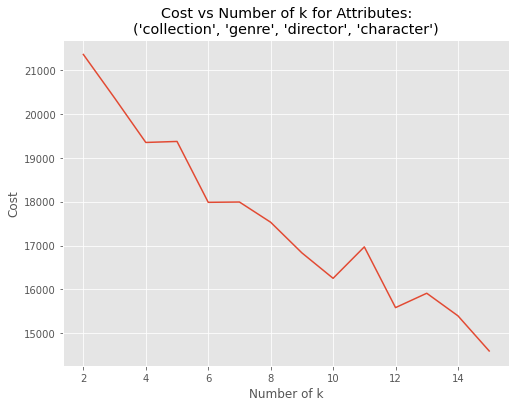

In [47]:
# categorical_attributes = {"collection": list(movies_ohe_df.columns[7:282]),
#                           "genre": list(movies_ohe_df.columns[282:302]),
#                           "company": list(movies_ohe_df.columns[302:526]),
#                           "director": list(movies_ohe_df.columns[526:617]),
#                           "character": list(movies_ohe_df.columns[617:992])}
selected_attribute_names = ("collection", "genre", "director", "character")
selected_attribute_columns = []
for element in selected_attribute_names:
    selected_attribute_columns.extend(categorical_attributes[element])
k = np.arange(2, 16)
kmodes_elbow_method(movies_ohe_df, columns=selected_attribute_columns, column_names=selected_attribute_names,
                    cluster_numbers=k)

From the graph above, we can say that the optimal number of k is 4. Now, let's fit k-modes clustering algorithm with k = 4 and see the results.

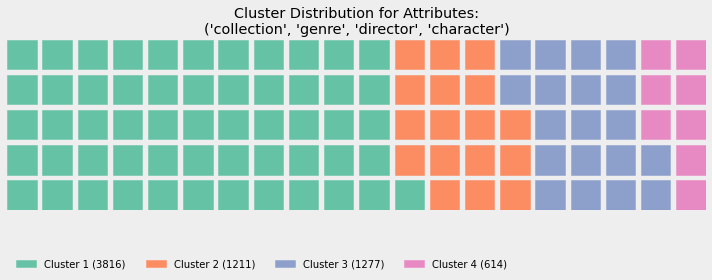

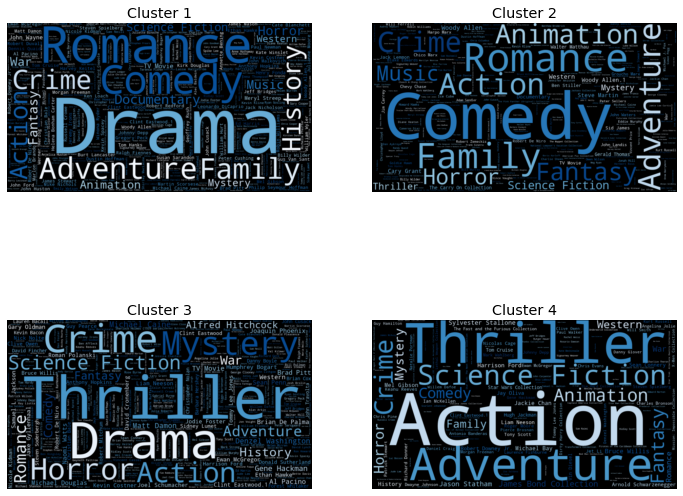

top_1_collection  \
Cluster 1        Harry Potter Collection (100.0%)   
Cluster 2        The Carry On Collection (100.0%)   
Cluster 3  Sherlock Holmes (1939 series) (100.0%)   
Cluster 4          James Bond Collection (100.0%)   

                          top_2_collection  \
Cluster 1        Rocky Collection (100.0%)   
Cluster 2      Jackass Collection (100.0%)   
Cluster 3  Jesse Stone Collection (100.0%)   
Cluster 4    Star Wars Collection (100.0%)   

                                          top_3_collection       top_1_genre  \
Cluster 1                  Tinker Bell Collection (100.0%)    Drama (76.57%)   
Cluster 2  National Lampoon's Vacation Collection (100.0%)    Comedy (56.4%)   
Cluster 3           The Hannibal Lecter Anthology (100.0%)  Thriller (76.9%)   
Cluster 4      The Fast and the Furious Collection (75.0%)   Action (47.56%)   

                 top_2_genre         top_3_genre             top_1_director  \
Cluster 1   Romance (71.03%)     Comedy (39.22%)   Martin Scorsese (80.77%)   
Cluster 2   Romance (20.84%)     Family (34.85%)       Woody Allen (46.51%)   
Cluster 3     Drama (23.43%)      Crime (44.01%)  Alfred Hitchcock (72.97%)   
Cluster 4  Thriller (19.92%)  Adventure (29.16%)       Michael Bay (83.33%)   

                    top_2_director           top_3_director  \
Cluster 1     Woody Allen (46.51%)       John Ford (90.91%)   
Cluster 2   Gerald Thomas (100.0%)     John Waters (100.0%)   
Cluster 3  Brian De Palma (68.75%)  Roman Polanski (47.37%)   
Cluster 4       Jay Oliva (81.82%)       Tony Scott (50.0%)   

                  top_1_character        top_2_character  \
Cluster 1     John Wayne (85.29%)  Meryl Streep (76.47%)   
Cluster 2  Woody Allen.1 (53.33%)     Cary Grant (50.0%)   
Cluster 3  Michael Caine (40.48%)  Gene Hackman (45.45%)   
Cluster 4  Jason Statham (83.33%)   Bruce Willis (40.0%)   

                       top_3_character  
Cluster 1         Henry Fonda (88.89%)  
Cluster 2        Steve Martin (71.43%)  
Cluster 3          Matt Damon (45.16%)  
Cluster 4  Sylvester Stallone (44.44%)

In [48]:
# selected_attribute_names = ("collection", "genre", "director", "character")
cluster_result, cluster_labels = kmodes_clustering_pipeline(movies_ohe_df, columns=selected_attribute_columns,
                                                            column_names=selected_attribute_names,
                                                            cluster_numbers=4)
cluster_result

Based on the waffleplot, we can say that the distribution of 4 clusters are good, all clusters have reasonable number of movies which range from 614 to 3816. According to the wordcloud, we can see that it's also a clean split and the results are interpretable.

After running k-modes clustering algorithm on two different combination of categorical attributes, we select the first clustering model as our best model because the results are interpretable and more interesting, specifically it has more clusters for the users to choose. The seleced categorical attributes are as follow:
* collection
* genre
* company
* director
* character

The final parameters for the k-modes clustering are as follow:
* n_clusters = 6
* init = Huang
* n_init = 5
* random_state = 0

The final cluster description is as follow:
* Cluster 1 - Thriller & Crime
* Cluster 2 - Action & Adventure
* Cluster 3 - Comedy & Drama
* Cluster 4 - Family & Animation
* Cluster 5 - Drama & Romance
* Cluster 6 - Horror & Mystery

## Agglomerative Clustering<a id=categorical_agglomerative><a>

To perform agglomerative clustering analysis on categorical attributes, let's define some functions specifically for agglomerative clustering.

In [49]:
def hamming_distance(selected_df):
    """Calculate hamming distance for selected attributes.
    
    Parameters:
        selected_df (DataFrame): DataFrame consisting selected attributes
        
    Returns:
        ndarray: Array consisting hamming distance matrix for selected attributes
    """
    
    input_array = np.array(selected_df)
    hamming_dist = np.zeros((len(input_array), len(input_array)))
    for i in range(len(input_array)):
        hamming_dist[:, i] = np.sum(input_array != input_array[i], axis=1)
    
    return hamming_dist

In [50]:
def agglomerative_categorical_pipeline(full_df, columns, column_names, cluster_numbers):
    """Pipeline to perform agglomerative clustering on selected attributes.
    
    Parameters:
        full_df (DataFrame): DataFrame consisting all attributes
        columns (list): List specifying the selected columns
        column_names (tuple): Tuple specifying the selected column names
        cluster_numbers (int): Number of cluster to obtain
    
    Display:
        Waffleplot: Waffleplot showing the distribution of clusters
        Wordcloud: Wordcloud showing the common items of each cluster
        
    Returns:
        DataFrame: DataFrame consisting top items for each cluster
        ndarray: Array consisting cluster labels
    """
    
    selected_df = select_attribute(full_df, columns)
    hamming_dist = hamming_distance(selected_df)
    ag = AgglomerativeClustering(n_clusters=cluster_numbers, linkage="complete", affinity="precomputed")
    ag.fit(hamming_dist)
    selected_df.insert(loc=selected_df.shape[1], column="Cluster", value=ag.labels_ + 1)
    top_items_df = cluster_top_items(selected_df, column_names)
    cluster_waffleplot(ag.labels_ + 1, column_names)
    cluster_wordcloud(selected_df)
    
    return top_items_df, ag.labels_ + 1

Now, let's proceed with the first categorical combination (collection, genre, company, director, character). Since the data is too huge, we cannot use dendrogram to determine the best number of cluster, so we will use trial and error method to find the best number of cluster. We will use complete linkage and hamming distance to perform the clustering analysis.

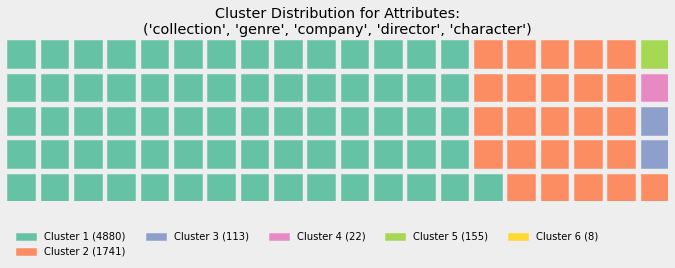

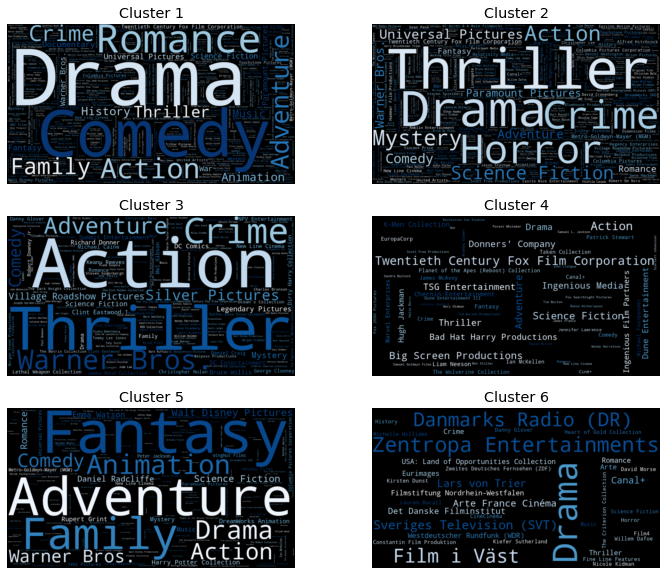

top_1_collection  \
Cluster 1                  James Bond Collection (80.95%)   
Cluster 2    The Fast and the Furious Collection (100.0%)   
Cluster 3                 Dirty Harry Collection (100.0%)   
Cluster 4                       X-Men Collection (100.0%)   
Cluster 5                Harry Potter Collection (100.0%)   
Cluster 6  USA: Land of Opportunities Collection (100.0%)   

                                 top_2_collection  \
Cluster 1        The Carry On Collection (100.0%)   
Cluster 2  Sherlock Holmes (1939 series) (100.0%)   
Cluster 3          James Bond Collection (19.05%)   
Cluster 4               Taken Collection (100.0%)   
Cluster 5               Shrek Collection (100.0%)   
Cluster 6        Heart of Gold Collection (50.0%)   

                                          top_3_collection        top_1_genre  \
Cluster 1                    Star Wars Collection (100.0%)     Drama (76.11%)   
Cluster 2         Frankenstein (Universal Series) (100.0%)  Thriller (70.76%)   
Cluster 3                Lethal Weapon Collection (100.0%)     Action (6.82%)   
Cluster 4  Planet of the Apes (Reboot) Collection (100.0%)     Action (1.24%)   
Cluster 5                   The Hobbit Collection (100.0%)   Fantasy (28.37%)   
Cluster 6                           TRON Collection (0.0%)       Drama (0.2%)   

                       top_2_genre        top_3_genre  \
Cluster 1          Comedy (90.45%)   Romance (91.56%)   
Cluster 2           Drama (22.42%)    Horror (87.48%)   
Cluster 3         Thriller (4.63%)      Crime (6.57%)   
Cluster 4  Science Fiction (2.05%)  Adventure (1.23%)   
Cluster 5       Adventure (12.63%)    Family (16.12%)   
Cluster 6         Thriller (0.12%)      Crime (0.18%)   

                                            top_1_company  \
Cluster 1                     Paramount Pictures (65.21%)   
Cluster 2                     Universal Pictures (36.43%)   
Cluster 3                           Warner Bros. (14.29%)   
Cluster 4  Twentieth Century Fox Film Corporation (5.33%)   
Cluster 5                            Warner Bros. (4.98%)   
Cluster 6                 Zentropa Entertainments (50.0%)   

                             top_2_company  \
Cluster 1      Universal Pictures (61.31%)   
Cluster 2             Warner Bros. (29.0%)   
Cluster 3         Silver Pictures (56.25%)   
Cluster 4  Big Screen Productions (91.67%)   
Cluster 5    Walt Disney Pictures (11.28%)   
Cluster 6     Danmarks Radio (DR) (63.64%)   

                                top_3_company             top_1_director  \
Cluster 1               Warner Bros. (51.73%)       Woody Allen (95.35%)   
Cluster 2         Paramount Pictures (32.99%)  Alfred Hitchcock (86.49%)   
Cluster 3  Village Roadshow Pictures (28.57%)    Richard Donner (42.86%)   
Cluster 4            Ingenious Media (64.29%)         Tim Burton (6.25%)   
Cluster 5               WingNut Films (50.0%)     Peter Jackson (58.33%)   
Cluster 6                Film i Väst (29.17%)    Lars von Trier (45.45%)   

                      top_2_director             top_3_director  \
Cluster 1         John Ford (90.91%)      Billy Wilder (82.61%)   
Cluster 2     Clint Eastwood (80.0%)  Steven Spielberg (55.17%)   
Cluster 3  Christopher Nolan (40.0%)     Clint Eastwood (10.0%)   
Cluster 4         Alan Parker (0.0%)       Phillip Noyce (0.0%)   
Cluster 5    Chris Columbus (27.27%)      Terry Gilliam (30.0%)   
Cluster 6         Alan Parker (0.0%)       Phillip Noyce (0.0%)   

                     top_1_character            top_2_character  \
Cluster 1      Meryl Streep (91.18%)        John Wayne (88.24%)   
Cluster 2     Peter Cushing (95.65%)  Clint Eastwood.1 (56.76%)   
Cluster 3  Clint Eastwood.1 (16.22%)       Bruce Willis (20.0%)   
Cluster 4       Hugh Jackman (35.0%)       Liam Neeson (16.67%)   
Cluster 5  Daniel Radcliffe (56.25%)        Emma Watson (75.0%)   
Cluster 6  Kiefer Sutherland (7.14%)       Nicole Kidman (3.7%)   

                     top_3_character  
Cluster 1 

In [51]:
categorical_attributes = {"collection": list(movies_ohe_df.columns[7:282]),
                          "genre": list(movies_ohe_df.columns[282:302]),
                          "company": list(movies_ohe_df.columns[302:526]),
                          "director": list(movies_ohe_df.columns[526:617]),
                          "character": list(movies_ohe_df.columns[617:992])}
selected_attribute_names = ("collection", "genre", "company", "director", "character")
selected_attribute_columns = []
for element in selected_attribute_names:
    selected_attribute_columns.extend(categorical_attributes[element])
cluster_result, cluster_labels = agglomerative_categorical_pipeline(movies_ohe_df,
                                                                    columns=selected_attribute_columns,
                                                                    column_names=selected_attribute_names,
                                                                    cluster_numbers=6)
cluster_result

After trial and error, we noticed that agglomerative clustering algorithm cannont produce very promising result, and the best number of cluster happened to be 6. Based on the waffleplot, we can say that the distribution of 6 clusters are very uneven, range from 8 to 4880. Besides, it seems like most of the movies were being grouped into Cluster 1 and 2, which defeated the purpose of clustering. And because of this, it makes the interpretation harder. In the next combination, we will try to drop the attribute company to see if the result will be better or not.

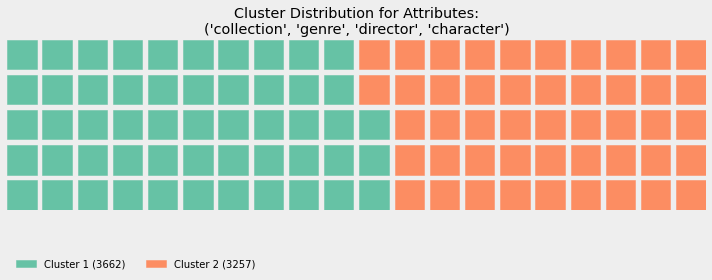

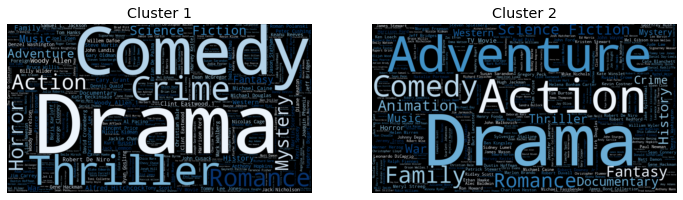

top_1_collection  \
Cluster 1  The Carry On Collection (100.0%)   
Cluster 2    James Bond Collection (71.43%)   

                                       top_2_collection  \
Cluster 1  The Fast and the Furious Collection (100.0%)   
Cluster 2                 Star Wars Collection (100.0%)   

                           top_3_collection     top_1_genre  \
Cluster 1    James Bond Collection (28.57%)  Drama (50.28%)   
Cluster 2  Harry Potter Collection (100.0%)  Drama (49.72%)   

                  top_2_genre        top_3_genre             top_1_director  \
Cluster 1     Comedy (71.82%)  Thriller (85.44%)       Woody Allen (88.37%)   
Cluster 2  Adventure (80.45%)    Action (50.35%)  Steven Spielberg (72.41%)   

                      top_2_director          top_3_director  \
Cluster 1  Alfred Hitchcock (94.59%)  Clint Eastwood (70.0%)   
Cluster 2         John Ford (90.91%)    John Huston (68.18%)   

                  top_1_character          top_2_character  \
Cluster 1  Woody Allen.1 (96.67%)  Robert De Niro (63.64%)   
Cluster 2     John Wayne (85.29%)    Meryl Streep (70.59%)   

                top_3_character  
Cluster 1    Cary Grant (90.0%)  
Cluster 2  Henry Fonda (81.48%)

In [52]:
# categorical_attributes = {"collection": list(movies_ohe_df.columns[7:282]),
#                           "genre": list(movies_ohe_df.columns[282:302]),
#                           "company": list(movies_ohe_df.columns[302:526]),
#                           "director": list(movies_ohe_df.columns[526:617]),
#                           "character": list(movies_ohe_df.columns[617:992])}
selected_attribute_names = ("collection", "genre", "director", "character")
selected_attribute_columns = []
for element in selected_attribute_names:
    selected_attribute_columns.extend(categorical_attributes[element])
cluster_result, cluster_labels = agglomerative_categorical_pipeline(movies_ohe_df,
                                                                    columns=selected_attribute_columns,
                                                                    column_names=selected_attribute_names,
                                                                    cluster_numbers=2)
cluster_result

After trial and error, we found out that the best number of cluster for this combination is 2. Based on the waffleplot, the distribution of 2 clusters are even, both having sufficient number of movies. And the split is quite clean according to the wordcloud, the results are very interpretable as well, but the only thing is too few clusters produced from this model.

After running agglomerative clustering algorithm on two different combination of categorical attributes, we select the second clustering model as our best model because the results are more interpretable. The seleced categorical attributes are as follow:
* collection
* genre
* director
* character

The final parameters for the agglomerative clustering are as follow:
* n_clusters = 2
* linkage = complete
* affinity = precomputed (hamming distance)

The final cluster description is as follow:
* Cluster 1 - Drama & Comedy & Thriller
* Cluster 2 - Drama & Adventure & Action

## Best Clustering Model<a id=categorical_best><a>

We select k-modes as the best clustering model for categorical attributes because the final model produces more clusters, and the results are more interesting, and able to recommend more relevant movies to the users. The result of best clustering model for categorical attributes are as follow.

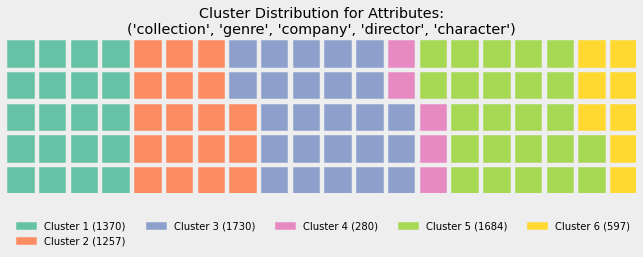

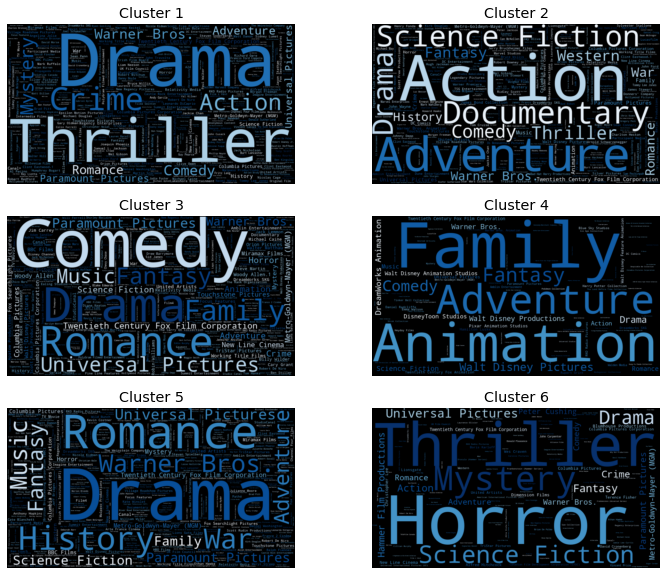

top_1_collection  \
Cluster 1  The Fast and the Furious Collection (87.5%)   
Cluster 2               James Bond Collection (95.24%)   
Cluster 3             The Carry On Collection (100.0%)   
Cluster 4             Harry Potter Collection (100.0%)   
Cluster 5                    Rocky Collection (100.0%)   
Cluster 6             Dracula (Hammer Series) (100.0%)   

                                          top_2_collection  \
Cluster 1                  Jesse Stone Collection (100.0%)   
Cluster 2                    Star Wars Collection (100.0%)   
Cluster 3  National Lampoon's Vacation Collection (100.0%)   
Cluster 4                  Tinker Bell Collection (100.0%)   
Cluster 5                       Step Up Collection (80.0%)   
Cluster 6            Frankenstein (Hammer Series) (100.0%)   

                          top_3_collection      top_1_genre  \
Cluster 1  Dirty Harry Collection (100.0%)   Drama (29.23%)   
Cluster 2        X-Men Collection (100.0%)  Action (64.45%)   
Cluster 3   The Muppet Collection (83.33%)  Comedy (80.62%)   
Cluster 4      Pokémon Collection (100.0%)  Family (44.14%)   
Cluster 5    Before... Collection (100.0%)   Drama (42.61%)   
Cluster 6          Saw Collection (100.0%)  Horror (72.02%)   

                  top_2_genre           top_3_genre  \
Cluster 1   Thriller (63.12%)        Crime (84.97%)   
Cluster 2  Adventure (46.93%)  Documentary (83.97%)   
Cluster 3      Drama (19.59%)      Romance (43.42%)   
Cluster 4  Animation (55.01%)    Adventure (22.57%)   
Cluster 5    Romance (38.25%)      History (54.37%)   
Cluster 6   Thriller (25.27%)      Mystery (30.94%)   

                           top_1_company  \
Cluster 1           Warner Bros. (29.0%)   
Cluster 2          Warner Bros. (19.26%)   
Cluster 3    Universal Pictures (30.15%)   
Cluster 4  Walt Disney Pictures (42.11%)   
Cluster 5          Warner Bros. (23.16%)   
Cluster 6    Universal Pictures (11.81%)   

                                             top_2_company  \
Cluster 1                      Paramount Pictures (22.16%)   
Cluster 2  Twentieth Century Fox Film Corporation (26.33%)   
Cluster 3                      Paramount Pictures (29.64%)   
Cluster 4                    DreamWorks Animation (81.82%)   
Cluster 5                      Universal Pictures (18.34%)   
Cluster 6                 Hammer Film Productions (90.32%)   

                              top_3_company             top_1_director  \
Cluster 1        Universal Pictures (19.6%)  Alfred Hitchcock (54.05%)   
Cluster 2       Paramount Pictures (20.88%)          John Ford (50.0%)   
Cluster 3             Warner Bros. (19.91%)        Woody Allen (81.4%)   
Cluster 4  Walt Disney Productions (53.85%)     Hamilton Luske (90.0%)   
Cluster 5        Paramount Pictures (18.3%)  Steven Spielberg (34.48%)   
Cluster 6        Paramount Pictures (6.96%)    Terence Fisher (100.0%)   

                      top_2_director             top_3_director  \
Cluster 1     Clint Eastwood (40.0%)      Sidney Lumet (57.89%)   
Cluster 2       Ridley Scott (45.0%)         Jay Oliva (81.82%)   
Cluster 3      Billy Wilder (60.87%)     Gerald Thomas (100.0%)   
Cluster 4    Chris Columbus (27.27%)  Steven Spielberg (10.34%)   
Cluster 5          Ken Loach (62.5%)     William Wyler (55.56%)   
Cluster 6  Alfred Hitchcock (32.43%)        Wes Craven (83.33%)   

                  top_1_character              top_2_character  \
Cluster 1  Michael Caine (42.86%)        Gene Hackman (51.52%)   
Cluster 2     John Wayne (85.29%)  Sylvester Stallone (55.56%)   
Cluster 3   Woody Allen.1 (90.0%)          Cary Grant (63.33%)   
Cluster 4   Rupert Grint (61.54%)         Emma Watson (66.67%)   
Cluster 5   Meryl Streep (52.94%)         Kate Winslet (60.0%)   
Cluster 6  Peter Cushing (82.61%)     Christopher Lee (86.67%)   

                     top_3_character  
Cluster 1  Denzel Washington (50.0%)  
Cluster 2  Clint Eastwood.1 (37.84%)  
Cluster 3      Steve Martin (71.43%)  
Cluster 4   Dani

In [53]:
categorical_attributes = {"collection": list(movies_ohe_df.columns[7:282]),
                          "genre": list(movies_ohe_df.columns[282:302]),
                          "company": list(movies_ohe_df.columns[302:526]),
                          "director": list(movies_ohe_df.columns[526:617]),
                          "character": list(movies_ohe_df.columns[617:992])}
selected_attribute_names = ("collection", "genre", "company", "director", "character")
selected_attribute_columns = []
for element in selected_attribute_names:
    selected_attribute_columns.extend(categorical_attributes[element])
cluster_result, cluster_labels = kmodes_clustering_pipeline(movies_ohe_df, columns=selected_attribute_columns,
                                                            column_names=selected_attribute_names,
                                                            cluster_numbers=6)
cluster_result

To recap, the interpretation of the best clustering model for categorical attributes are as follow:
* Cluster 1 - Thriller & Crime
* Cluster 2 - Action & Adventure
* Cluster 3 - Comedy & Drama
* Cluster 4 - Family & Animation
* Cluster 5 - Drama & Romance
* Cluster 6 - Horror & Mystery

The selected categorical attributes are as follow:
* collection
* genre
* company
* director
* character

The final parameters for the k-modes clustering are as follow:
* n_clusters = 6
* init = Huang
* n_init = 5
* random_state = 0

Now let's look at some example of movies from each cluster. Before that, let's define a function to do that.

In [54]:
def view_cluster_examples(full_df, cluster_labels, cluster_to_view):
    """View some examples of a cluster.
    
    Paramaters:
        full_df (DataFrame): DataFrame consisting all attributes
        cluster_labels (ndarray): Array consisting cluster labels
        cluster_to_view (int): Number of cluster to view
    
    Return:
        DataFrame: DataFrame consisting 5 examples in the selected cluster
    """
    
    selected_df = full_df.copy()
    selected_df.insert(loc=selected_df.shape[1], column="Cluster" , value=cluster_labels)
    
    return selected_df.loc[selected_df["Cluster"] == cluster_to_view, :].sample(5)

In [55]:
# Cluster 1 - Thriller & Crime
movies_df = pd.read_csv("movies_metadata_cleaned.csv", parse_dates=['release_date'])
movies_df.loc[:, "release_date"] = movies_df['release_date'].dt.year
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=1)

belongs_to_collection                                    genres     id  \
4345                   NaN              ['Action', 'Crime', 'Drama']  60753   
4                      NaN  ['Action', 'Crime', 'Drama', 'Thriller']      6   
3674                   NaN              ['Action', 'Crime', 'Drama']  34583   
2599                   NaN  ['Action', 'Crime', 'Drama', 'Thriller']   6506   
2033                   NaN           ['Action', 'Drama', 'Thriller']   4751   

      popularity                               production_companies  \
4345    9.094276  ['Pantry Films', 'Stage 6 Films', 'Tooley Prod...   
4      17.924927  ['Regency Enterprises', 'Forward Pass', 'Warne...   
3674    3.156583                            ['Cinema Center Films']   
2599    4.788907  ['Milky Way Image Company', 'Team Work Motion ...   
2033    5.432879          ['Paramount Pictures', 'Rastar Pictures']   

      release_date  runtime            title  vote_average  vote_count  \
4345          2008    103.0            Felon           7.1       239.0   
4             1995    170.0             Heat           7.7      1886.0   
3674          1972     88.0        Prime Cut           6.1        26.0   
2599          2001    102.0  Fulltime Killer           6.6        34.0   
2033          1980     93.0       The Hunter           6.2        26.0   

                         directors  \
4345           ['Ric Roman Waugh']   
4                 ['Michael Mann']   
3674           ['Michael Ritchie']   
2599  ['Johnnie To', 'Wai Ka-Fai']   
2033                ['Buzz Kulik']   

                                             characters  Cluster  
4345  ['Stephen Dorff', 'Val Kilmer', 'Marisol Nicho...        1  
4         ['Al Pacino', 'Robert De Niro', 'Val Kilmer']        1  
3674   ['Lee Marvin', 'Gene Hackman', 'Angel Tompkins']        1  
2599     ['Takashi Sorimachi', 'Andy Lau', 'Kelly Lin']        1  
2033  ['Steve McQueen', 'Eli Wallach', 'Kathryn Harr...        1

In [56]:
# Cluster 2 - Action & Adventure
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=2)

belongs_to_collection  \
3038  In China They Eat Dogs Collection   
6018                                NaN   
1052     Romancing the Stone Collection   
2098                                NaN   
2404                                NaN   

                                            genres      id  popularity  \
3038                 ['Action', 'Comedy', 'Crime']    8117    5.062640   
6018            ['Documentary', 'Science Fiction']  122288    9.582390   
1052  ['Action', 'Adventure', 'Comedy', 'Romance']    2406    6.827193   
2098                    ['Action', 'Drama', 'War']    4918   12.654551   
2404    ['Action', 'Adventure', 'Science Fiction']    5830    3.419312   

                                   production_companies  release_date  \
3038                    ['Steen Herdel Filmproduktion']          1999   
6018  ['Le Big Boss Productions', 'Ballinran Product...          2011   
1052  ['Twentieth Century Fox Film Corporation', 'SL...          1984   
2098         ['Twentieth Century Fox Film Corporation']          1958   
2404                                   ['Ameran Films']          1961   

      runtime                   title  vote_average  vote_count  \
3038     91.0  In China They Eat Dogs           7.5        81.0   
6018     97.0            The Captains           6.5        40.0   
1052    106.0     Romancing the Stone           6.6       477.0   
2098    167.0         The Young Lions           6.4        22.0   
2404    101.0       Mysterious Island           6.2        38.0   

                  directors  \
3038  ['Lasse Spang Olsen']   
6018    ['William Shatner']   
1052    ['Robert Zemeckis']   
2098     ['Edward Dmytryk']   
2404        ['Cy Endfield']   

                                             characters  Cluster  
3038   ['Dejan Čukić', 'Kim Bodnia', 'Brian Patterson']        2  
6018  ['William Shatner', 'Patrick Stewart', 'Avery ...        2  
1052  ['Michael Douglas', 'Kathleen Turner', 'Danny ...        2  
2098  ['Marlon Brando', 'Montgomery Clift', 'Dean Ma...        2  
2404  ['Michael Craig', 'Joan Greenwood', 'Michael C...        2

In [57]:
# Cluster 3 - Comedy & Drama
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=3)

belongs_to_collection  \
5218  Best Exotic Marigold Hotel Collection   
4500                                    NaN   
1081                                    NaN   
2678                                    NaN   
5143                                    NaN   

                                       genres     id  popularity  \
5218                      ['Drama', 'Comedy']  94070    9.230460   
4500                               ['Comedy']  67734    6.778870   
1081                               ['Comedy']   2463    7.427491   
2678  ['Comedy', 'Drama', 'Western', 'Music']   6785    5.748536   
5143                      ['Comedy', 'Drama']  91448    6.756741   

                                   production_companies  release_date  \
5218  ['Participant Media', 'Imagenation Abu Dhabi FZ']          2011   
4500  ['Miramax Films', 'Sidney Kimmel Entertainment...          2009   
1081                            ['Touchstone Pictures']          1986   
2678                      ['Metro-Goldwyn-Mayer (MGM)']          1954   
5143                         ['Red Carpet Productions']          2009   

      runtime                            title  vote_average  vote_count  \
5218    124.0   The Best Exotic Marigold Hotel           6.9       468.0   
4500    107.0                    Adventureland           6.4       748.0   
1081     93.0                  Ruthless People           6.7       104.0   
2678    102.0  Seven Brides for Seven Brothers           7.1       117.0   
5143     92.0                 Accidents Happen           6.2        22.0   

                                             directors  \
5218                                   ['John Madden']   
4500                                  ['Greg Mottola']   
1081  ['Jim Abrahams', 'David Zucker', 'Jerry Zucker']   
2678                                 ['Stanley Donen']   
5143                              ['Andrew Lancaster']   

                                             characters  Cluster  
5218    ['Bill Nighy', 'Maggie Smith', 'Tom Wilkinson']        3  
4500  ['Jesse Eisenberg', 'Kristen Stewart', 'Martin...        3  
1081  ['Danny DeVito', 'Bette Midler', 'Judge Reinho...        3  
2678   ['Howard Keel', 'Jeff Richards', 'Russ Tamblyn']        3  
5143  ['Geena Davis', 'Harrison Gilbertson', 'Harry ...        3

In [58]:
# Cluster 4 - Family & Animation
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=4)

belongs_to_collection  \
2511                    Born Free Trilogy   
861                                   NaN   
413                 Caballeros Collection   
1797  The Brave Little Toaster Collection   
6874             Despicable Me Collection   

                                                 genres      id  popularity  \
2511                   ['Family', 'Adventure', 'Drama']    6232    2.672431   
861          ['Family', 'Science Fiction', 'Adventure']    2046    5.526865   
413                    ['Animation', 'Family', 'Music']    1024    8.702472   
1797  ['Fantasy', 'Adventure', 'Animation', 'Comedy'...    4090    6.649391   
6874  ['Action', 'Animation', 'Adventure', 'Family',...  172547   36.631519   

                                   production_companies  release_date  \
2511                                      ['High Road']          1966   
861   ['Walt Disney Pictures', 'New Star Entertainme...          1986   
413                            ['Walt Disney Pictures']          1944   
1797  ['The Kushner-Locke Company', 'Hyperion Pictur...          1987   
6874                     ['Illumination Entertainment']          2017   

      runtime                     title  vote_average  vote_count  \
2511     95.0                 Born Free           6.5        38.0   
861      90.0   Flight of the Navigator           6.9       227.0   
413      71.0      The Three Caballeros           6.2       108.0   
1797     90.0  The Brave Little Toaster           6.8        94.0   
6874     96.0           Despicable Me 3           6.2      2002.0   

                                              directors  \
2511                                     ['James Hill']   
861                                  ['Randal Kleiser']   
413   ['William Roberts', 'Clyde Geronimi', 'Jack Ki...   
1797                                     ['Jerry Rees']   
6874                    ['Kyle Balda', 'Pierre Coffin']   

                                             characters  Cluster  
2511  ['Virginia McKenna', 'Bill Travers', 'Geoffrey...        4  
861                                     ['Joey Cramer']        4  
413                                                 NaN        4  
1797                                                NaN        4  
6874                                                NaN        4

In [59]:
# Cluster 5 - Drama & Romance
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=5)

belongs_to_collection                                   genres     id  \
1314                   NaN  ['Romance', 'Drama', 'Science Fiction']   3008   
2462                   NaN                     ['Drama', 'Romance']   6031   
215                    NaN                       ['Drama', 'Music']    477   
2847                   NaN                     ['Drama', 'Romance']   7184   
3440                   NaN                      ['Drama', 'Family']  26760   

      popularity                              production_companies  \
1314    5.466969                                      ['Cineplex']   
2462    4.480053         ['Universal International Pictures (UI)']   
215    14.820883                           ['Touchstone Pictures']   
2847    3.732049  ['Paramount Pictures', 'Seven Arts Productions']   
3440    6.254895                          ['Walt Disney Pictures']   

      release_date  runtime                          title  vote_average  \
1314          1998     95.0                     Last Night           7.0   
2462          1959    125.0              Imitation of Life           7.2   
215           1993    118.0  What's Love Got to Do with It           6.9   
2847          1966    110.0     This Property Is Condemned           6.1   
3440          1991     88.0    Wild Hearts Can't Be Broken           7.4   

      vote_count           directors  \
1314        41.0    ['Don McKellar']   
2462        62.0    ['Douglas Sirk']   
215         75.0    ['Brian Gibson']   
2847        25.0  ['Sydney Pollack']   
3440        25.0     ['Steve Miner']   

                                             characters  Cluster  
1314   ['Don McKellar', 'Sandra Oh', 'Roberta Maxwell']        5  
2462     ['Lana Turner', 'Juanita Moore', 'John Gavin']        5  
215   ['Angela Bassett', 'Laurence Fishburne', 'Vane...        5  
2847  ['Natalie Wood', 'Robert Redford', 'Charles Br...        5  
3440  ['Gabrielle Anwar', 'Cliff Robertson', 'Michae...        5

In [60]:
# Cluster 6 - Horror & Mystery
view_cluster_examples(movies_df, cluster_labels, cluster_to_view=6)

belongs_to_collection  \
1218         The Omen Collection   
5894                         NaN   
1603  Quatermass (Hammer series)   
23                           NaN   
5496      World War Z Collection   

                                                 genres      id  popularity  \
1218          ['Action', 'Drama', 'Horror', 'Thriller']    2789   10.235373   
5894                    ['Thriller', 'Science Fiction']  115680    9.646738   
1603                      ['Horror', 'Science Fiction']    3658    9.347228   
23           ['Science Fiction', 'Thriller', 'Mystery']      32   12.297305   
5496  ['Action', 'Drama', 'Horror', 'Science Fiction...  103249   26.114917   

                                   production_companies  release_date  \
1218  ['Twentieth Century Fox Film Corporation', 'Ma...          1978   
5894  ['Uncooperative Pictures', 'XLrator Media', 'R...          2014   
1603                        ['Hammer Film Productions']          1967   
23    ['Universal Pictures', 'Atlas Entertainment', ...          1995   
5496  ['Paramount Pictures', 'GK Films', 'Skydance P...          2013   

      runtime                   title  vote_average  vote_count  \
1218    107.0         Damien: Omen II           6.1       170.0   
5894    104.0              Time Lapse           6.4       383.0   
1603     97.0  Quatermass and the Pit           6.2        57.0   
23      129.0          Twelve Monkeys           7.4      2470.0   
5496    116.0             World War Z           6.7      5683.0   

                          directors  \
1218  ['Don Taylor', 'Mike Hodges']   
5894               ['Bradley King']   
1603             ['Roy Ward Baker']   
23                ['Terry Gilliam']   
5496               ['Marc Forster']   

                                             characters  Cluster  
1218  ['William Holden', 'Lee Grant', 'Jonathan Scot...        6  
5894  ['Danielle Panabaker', "Matt O'Leary", 'George...        6  
1603  ['James Donald', 'Andrew Keir', 'Barbara Shell...        6  
23     ['Bruce Willis', 'Madeleine Stowe', 'Brad Pitt']        6  
5496  ['Brad Pitt', 'Mireille Enos', 'Abigail Hargro...        6

## Recommend Nearest Neighbors<a id=categorical_neighbors><a>

To recommend the nearest neighbors in the same cluster to the users based on their watching history, we need to calculate the hamming distance of the movie being watched with all the other movies based on the attributes that we selected namely collection, genre, company, director and character. To accomplish that, let's define a function for it.

In [61]:
def nearest_neighbors_hamming(ohe_df, df, cluster_labels, selected_movie_id):
    """Use hamming distance to find out the nearest neighbors within the same cluster.
    
    Paramaters:
        ohe_df (DataFrame): DataFrame consisting all attributes after performing one hot encoding
        df (DataFrame): DataFrame consisting all attributes before performing one hot encoding
        cluster_labels (ndarray): Array consisting cluster labels
        selected_movie_id (int): Movie ID being watched
    
    Return:
        DataFrame: DataFrame consisting 5 nearest neighbors
    """

    nearest_neighbors_df = df.copy()
    selected_df = ohe_df.copy()
    selected_df.insert(loc=selected_df.shape[1], column="Cluster" , value=cluster_labels)
    selected_cluster = int(selected_df.loc[selected_df["id"] == selected_movie_id, "Cluster"])
    selected_df = selected_df.loc[selected_df["Cluster"] == selected_cluster, :]
    selected_movie = np.array(selected_df.loc[selected_df["id"] == selected_movie_id,
                                              selected_df.columns[7:-1]])
    nearest_neighbors_df = nearest_neighbors_df.loc[nearest_neighbors_df["id"].isin(selected_df["id"]), :]
    nearest_neighbors_df["Cluster"] = selected_df["Cluster"]
    selected_df = np.array(selected_df.iloc[:, 7:-1])
    hamming_dist = np.sum(selected_df != selected_movie, axis=1)
    nearest_neighbors_df.insert(loc=nearest_neighbors_df.shape[1], column="Hamming Distance", value=hamming_dist)
    nearest_neighbors_df = nearest_neighbors_df.sort_values("Hamming Distance").head(6)[1:]
    
    return nearest_neighbors_df

Now, let's try the nearest_neighbors_hamming function with the movie "Guardians of the Galaxy". The details of the movie are as follow:
* id = 112852
* title = Guardians of the Galaxy
* collection = Guardians of the Galaxy Collection
* genre = Action, Science Fiction, Adventure
* company = Marvel Studios, Moving Picture Company
* director = James Gunn
* characters = Chris Pratt, Zoe Saldana, Dave Bautista

In [62]:
nearest_neighbors_hamming(movies_ohe_df, movies_df, cluster_labels, selected_movie_id=112852)

belongs_to_collection  \
6030  Guardians of the Galaxy Collection   
2404                                 NaN   
2716                                 NaN   
6028                  Ant-Man Collection   
6360                                 NaN   

                                                 genres      id  popularity  \
6030  ['Action', 'Adventure', 'Comedy', 'Science Fic...  122918  185.330992   
2404         ['Action', 'Adventure', 'Science Fiction']    5830    3.419312   
2716         ['Action', 'Adventure', 'Science Fiction']    6882    4.223815   
6028         ['Science Fiction', 'Action', 'Adventure']  122900   26.882388   
6360         ['Action', 'Adventure', 'Science Fiction']  142509   14.544852   

                                   production_companies  release_date  \
6030         ['Walt Disney Pictures', 'Marvel Studios']          2017   
2404                                   ['Ameran Films']          1961   
2716  ['Fuji Television Network', 'Amuse Pictures', ...          2002   
6028                                 ['Marvel Studios']          2015   
6360  ['Bazelevs Production', 'Huayi Brothers Media'...          2015   

      runtime                           title  vote_average  vote_count  \
6030    137.0  Guardians of the Galaxy Vol. 2           7.6      4858.0   
2404    101.0               Mysterious Island           6.2        38.0   
2716    116.0                        Returner           6.7        43.0   
6028    117.0                         Ant-Man           7.0      6029.0   
6360     97.0                  Hardcore Henry           6.2       780.0   

                 directors                                         characters  \
6030        ['James Gunn']    ['Chris Pratt', 'Zoe Saldana', 'Dave Bautista']   
2404       ['Cy Endfield']  ['Michael Craig', 'Joan Greenwood', 'Michael C...   
2716  ['Takashi Yamazaki']  ['Takeshi Kaneshiro', 'Anne Suzuki', 'Kirin Ki...   
6028       ['Peyton Reed']  ['Paul Rudd', 'Michael Douglas', 'Evangeline L...   
6360   ['Ilya Naishuller']  ['Sharlto Copley', 'Haley Bennett', 'Danila Ko...   

      Cluster  Hamming Distance  
6030        2                 3  
2404        2                 4  
2716        2                 4  
6028        2                 4  
6360        2                 4

The 5 nearest neighbors appeared as expected!

# C. Summary<a id=summary><a>

In summary, we have discovered two types of cluster, one is for numerical attributes, one is for categorical attributes as follow:

* Numerical Attributes:
    * Cluster 1 - Extremely old but high rating movies 
    * Cluster 2 - Popular movies
    * Cluster 3 - Extremely popular movies 
    * Cluster 4 - Old but popular movies


* Categorical Attributes:
    * Cluster 1 - Thriller & Crime
    * Cluster 2 - Action & Adventure
    * Cluster 3 - Comedy & Drama
    * Cluster 4 - Family & Animation
    * Cluster 5 - Drama & Romance
    * Cluster 6 - Horror & Mystery
    
By grouping movies into these clusters, it could give new insights to the users. For example, some users might be curious of how good are those old and classic movies. Out of curiosity, they might start watching the movies in the cluster "extremely old but high rating movies". For those who like popular movies, they will most probably start watching from "extremely popular movies". However, some people might prefer certain genre. In that case, they can click on the cluster that suit them the best such as "Horror & Mystery", "Family & Animation", etc. Besides, we also created two function to recommend 5 nearest neighbors to the users after they finish watching a movie. For numerical attributes, we use euclidean distance to recommend the nearest neighbors. For categorical attributes, we use hamming distance to recommend the nearest neighbors. So, it could help users to search for other similar movies. In short, by having these features, it could improve users experience by recommending more relevant movies to the users. 

# Experiment Set 3

# Association Rules Mining <a id=association_all><a>

In [63]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
pd.set_option('display.max_columns', None)

In [64]:
ratings_all = pd.read_csv("ratings_all.csv")
ratings_all.head()

userId                                            movieId
0       1  [2762, 54503, 112552, 96821, 5577, 92439, 4878...
1       2   [648, 260, 1356, 628, 1210, 1233, 605, 377, 339]
2       3                                         [527, 858]
3       4  [4014, 4896, 1221, 1097, 2023, 1197, 2706, 235...
4       5  [1230, 1302, 1270, 3079, 3114, 3156, 2707, 858...

## One-Hot-Encoding <a id=onehot_all><a>

To be honest, we have stucked on this stage for a few dayas because the memory consumption is too huge, which has a estimated of 40-50 GB memory consumption. For a personal computer with 8 to 20GB RAM is unable to process, which will stop in the midst of the process. Eventually, I have rent a high memory PC (from Taobao in China) to process this code.

In [65]:
%%time
from ast import literal_eval
ratings_all.movieId = ratings_all.movieId.apply(literal_eval)
s = ratings_all['movieId'].explode()
ratings_all = ratings_all[['userId']].join(pd.crosstab(s.index, s))
ratings_all = ratings_all.drop('userId', axis = 1)
print(f"ratings_all data shape : {ratings_all.shape}")
ratings_all.head()

ratings_all data shape : (265662, 6893)
CPU times: user 5min 55s, sys: 1min 22s, total: 7min 18s
Wall time: 7min 18s


1       2       3       4       6       7       10      11      13      \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   14      16      17      18      19      21      22      23      24      \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   25      26      27      28      31      32      34      36      38      \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   39      41      42      43      45      46      47      48      50      \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   52      57      62      63      69      70      72      76      78      \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   81      86      88      89      94      100     101     104     105     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   107     110     111     112     123     125     141     144     145     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   147     149     150     151     152     155     156     158     159     \
0       1       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   161     162     163     164     165     170     175     176     180     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0   

## Apriori-Algorithm <a id=apriori_all><a>

In [66]:
def association_all(data_rating):
    frequent = apriori(data_rating, min_support = 0.07, use_colnames = True)
    frequent['length'] = frequent['itemsets'].apply(lambda x: len(x))
    frequent[(frequent['length'] == 2) & \
             (frequent['support'] >= 0.07)]
    data_rating = association_rules(frequent, metric = "lift", min_threshold = 1)
    data_rating = data_rating[(data_rating['lift'] >= 2) & (data_rating['confidence'] >= 0.7)]
    return data_rating

In [67]:
association_all(ratings_all)

antecedents   consequents  antecedent support  \
55                  (47)         (296)            0.162846   
57                  (47)         (318)            0.162846   
67                  (47)         (593)            0.162846   
92                  (50)         (318)            0.198824   
175                (111)         (296)            0.097312   
...                  ...           ...                 ...   
2803  (5952, 4993, 2959)        (2571)            0.085654   
2804  (5952, 2571, 2959)        (4993)            0.078212   
2805  (4993, 2571, 2959)        (5952)            0.085511   
2808        (5952, 2959)  (4993, 2571)            0.092531   
2810        (4993, 2959)  (5952, 2571)            0.102179   

      consequent support   support  confidence      lift  leverage  conviction  
55              0.272380  0.120932    0.742615  2.726393  0.076576    2.826969  
57              0.313330  0.114032    0.700245  2.234845  0.063007    2.290769  
67              0.268484  0.114973    0.706024  2.629668  0.071252    2.488351  
92              0.313330  0.141819    0.713290  2.276480  0.079522    2.395000  
175             0.272380  0.072363    0.743618  2.730074  0.045857    2.838026  
...                  ...       ...         ...       ...       ...         ...  
2803            0.248579  0.073673    0.860119  3.460142  0.052381    5.371846  
2804            0.179205  0.073673    0.941958  5.256310  0.059657   14.141356  
2805            0.163595  0.073673    0.861557  5.266401  0.059683    6.041529  
2808            0.127809  0.073673    0.796192  6.229547  0.061846    4.279481  
2810            0.116038  0.073673    0.721017  6.213603  0.061816    3.168511  

[562 rows x 9 columns]

## Replacing with Movie Titles <a id=replace_all><a>

Select movie id and title from the movies_metadata_cleaned. This is to match between the association rules and the databae in order to replace movie id to movie title

In [68]:
movies_metadata_cleaned = pd.read_csv("movies_metadata_cleaned.csv")
movies = movies_metadata_cleaned[['id', 'title']]
movies.head()

id              title
0   1          Toy Story
1   2            Jumanji
2   3   Grumpier Old Men
3   4  Waiting to Exhale
4   6               Heat

Define the coding of replacing the movie id with movie title. The association rules generated from Apriori have frozen the dataset. So that we need to unfrozen the data first only can do replacing

In [69]:
def transform3a_2c(rules_data):
    # unfrozen the dataframe
    a = [list(x) for x in rules_data.antecedents.values]
    c = [list(x) for x in rules_data.consequents.values]
    r = pd.DataFrame(np.array(a),
                       columns=['antecedents'])
    c = pd.DataFrame(np.array(c),
                       columns=['consequents'])
    r['consequents'] = c
    r[['antecedent 1','antecedent 2', 'antecedent 3']] = pd.DataFrame(r.antecedents.tolist(), index= r.index)
    r[['consequent 1', 'consequent 2']] = pd.DataFrame(r.consequents.tolist(), index= r.index)
    r.drop(['antecedents','consequents'],inplace=True,axis=1)
    # replace ant1
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 1'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 1'})
    # replace ant2
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 2'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 2'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 2'})
    # replace ant3
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 3'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 3'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 3'})
    # replace con1
    r = pd.merge(r, movies,  how='left', left_on=['consequent 1'], 
                             right_on = ['id'])
    r.drop(['id','consequent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 1'})
    # replace con2
    r = pd.merge(r, movies,  how='left', left_on=['consequent 2'], 
                             right_on = ['id'])
    r.drop(['id','consequent 2'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 2'})
    # add metrics
    lift = rules_data[['lift']].reset_index(drop = True)
    r['lift'] = lift
    confidence = rules_data[['confidence']].reset_index(drop = True)
    r['confidence'] = confidence
    support = rules_data[['support']].reset_index(drop = True)
    r['support'] = support
    # sort
    r = r.sort_values(by=['lift'],ascending=False)
    r
    return r

In [70]:
transform3a_2c(association_all(ratings_all))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


antecedent 1  \
52                                   Kill Bill: Vol. 2   
51                                   Kill Bill: Vol. 1   
513              The Lord of the Rings: The Two Towers   
514  The Lord of the Rings: The Fellowship of the Ring   
512              The Lord of the Rings: The Two Towers   
..                                                 ...   
128                                       Forrest Gump   
284                                       Forrest Gump   
297                                      Jurassic Park   
12                              Leon: The Professional   
1                                                Se7en   

                   antecedent 2 antecedent 3  \
52                          NaN          NaN   
51                          NaN          NaN   
513                   Star Wars          NaN   
514     The Empire Strikes Back          NaN   
512     The Empire Strikes Back          NaN   
..                          ...          ...   
128                   Star Wars          NaN   
284  Terminator 2: Judgment Day          NaN   
297    The Silence of the Lambs          NaN   
12                          NaN          NaN   
1                           NaN          NaN   

                                          consequent 1  \
52                                   Kill Bill: Vol. 1   
51                                   Kill Bill: Vol. 2   
513  The Lord of the Rings: The Fellowship of the Ring   
514              The Lord of the Rings: The Two Towers   
512  The Lord of the Rings: The Fellowship of the Ring   
..                                                 ...   
128                           The Shawshank Redemption   
284                           The Shawshank Redemption   
297                           The Shawshank Redemption   
12                            The Shawshank Redemption   
1                             The Shawshank Redemption   

                consequent 2      lift  confidence   support  
52                       NaN  8.987646    0.869595  0.070710  
51                       NaN  8.987646    0.730820  0.070710  
513  The Empire Strikes Back  8.391762    0.817722  0.076597  
514                Star Wars  8.391762    0.786070  0.076597  
512                Star Wars  8.357751    0.858137  0.076597  
..                       ...       ...         ...       ...  
128                      NaN  2.267038    0.710332  0.077870  
284                      NaN  2.256746    0.707107  0.075536  
297                      NaN  2.248996    0.704679  0.071828  
12                       NaN  2.241624    0.702369  0.075212  
1                        NaN  2.234845    0.700245  0.114032  

[562 rows x 8 columns]

## Extract Interesting Insights <a id=insights><a>

### Explore interesting rules or insights by replacing "directors"

In [71]:
movies_metadata_cleaned = pd.read_csv("movies_metadata_cleaned.csv")
movies = movies_metadata_cleaned[['id', 'directors']]
movies = movies.rename(columns = {'directors': 'title'})

In [72]:
transform3a_2c(association_all(ratings_all))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


antecedent 1        antecedent 2 antecedent 3  \
52   ['Quentin Tarantino']                 NaN          NaN   
51   ['Quentin Tarantino']                 NaN          NaN   
513      ['Peter Jackson']    ['George Lucas']          NaN   
514      ['Peter Jackson']  ['Irvin Kershner']          NaN   
512      ['Peter Jackson']  ['Irvin Kershner']          NaN   
..                     ...                 ...          ...   
128    ['Robert Zemeckis']    ['George Lucas']          NaN   
284    ['Robert Zemeckis']   ['James Cameron']          NaN   
297   ['Steven Spielberg']  ['Jonathan Demme']          NaN   
12          ['Luc Besson']                 NaN          NaN   
1        ['David Fincher']                 NaN          NaN   

              consequent 1        consequent 2      lift  confidence   support  
52   ['Quentin Tarantino']                 NaN  8.987646    0.869595  0.070710  
51   ['Quentin Tarantino']                 NaN  8.987646    0.730820  0.070710  
513      ['Peter Jackson']  ['Irvin Kershner']  8.391762    0.817722  0.076597  
514      ['Peter Jackson']    ['George Lucas']  8.391762    0.786070  0.076597  
512      ['Peter Jackson']    ['George Lucas']  8.357751    0.858137  0.076597  
..                     ...                 ...       ...         ...       ...  
128     ['Frank Darabont']                 NaN  2.267038    0.710332  0.077870  
284     ['Frank Darabont']                 NaN  2.256746    0.707107  0.075536  
297     ['Frank Darabont']                 NaN  2.248996    0.704679  0.071828  
12      ['Frank Darabont']                 NaN  2.241624    0.702369  0.075212  
1       ['Frank Darabont']                 NaN  2.234845    0.700245  0.114032  

[562 rows x 8 columns]

### Explore interesting rules or insights by replacing "production companies"

In [73]:
movies_metadata_cleaned = pd.read_csv("movies_metadata_cleaned.csv")
movies = movies_metadata_cleaned[['id', 'production_companies']]
movies = movies.rename(columns = {'production_companies': 'title'})

In [74]:
transform3a_2c(association_all(ratings_all))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


antecedent 1  \
52   ['Miramax Films', 'A Band Apart', 'Super Cool ...   
51   ['Miramax Films', 'A Band Apart', 'Super Cool ...   
513  ['WingNut Films', 'New Line Cinema', 'The Saul...   
514  ['WingNut Films', 'New Line Cinema', 'The Saul...   
512  ['WingNut Films', 'New Line Cinema', 'The Saul...   
..                                                 ...   
128                             ['Paramount Pictures']   
284                             ['Paramount Pictures']   
297     ['Universal Pictures', 'Amblin Entertainment']   
12                    ['Columbia Pictures', 'Gaumont']   
1    ['New Line Cinema', 'Juno Pix', 'Cecchi Gori P...   

                                          antecedent 2 antecedent 3  \
52                                                 NaN          NaN   
51                                                 NaN          NaN   
513  ['Lucasfilm', 'Twentieth Century Fox Film Corp...          NaN   
514  ['Lucasfilm', 'Twentieth Century Fox Film Corp...          NaN   
512  ['Lucasfilm', 'Twentieth Century Fox Film Corp...          NaN   
..                                                 ...          ...   
128  ['Lucasfilm', 'Twentieth Century Fox Film Corp...          NaN   
284  ['Lightstorm Entertainment', 'Pacific Western'...          NaN   
297  ['Orion Pictures', 'Strong Heart/Demme Product...          NaN   
12                                                 NaN          NaN   
1                                                  NaN          NaN   

                                          consequent 1  \
52   ['Miramax Films', 'A Band Apart', 'Super Cool ...   
51   ['Miramax Films', 'A Band Apart', 'Super Cool ...   
513  ['WingNut Films', 'New Line Cinema', 'The Saul...   
514  ['WingNut Films', 'New Line Cinema', 'The Saul...   
512  ['WingNut Films', 'New Line Cinema', 'The Saul...   
..                                                 ...   
128      ['Castle Rock Entertainment', 'Warner Bros.']   
284      ['Castle Rock Entertainment', 'Warner Bros.']   
297      ['Castle Rock Entertainment', 'Warner Bros.']   
12       ['Castle Rock Entertainment', 'Warner Bros.']   
1        ['Castle Rock Entertainment', 'Warner Bros.']   

                                          consequent 2      lift  confidence  \
52                                                 NaN  8.987646    0.869595   
51                                                 NaN  8.987646    0.730820   
513  ['Lucasfilm', 'Twentieth Century Fox Film Corp...  8.391762    0.817722   
514  ['Lucasfilm', 'Twentieth Century Fox Film Corp...  8.391762    0.786070   
512  ['Lucasfilm', 'Twentieth Century Fox Film Corp...  8.357751    0.858137   
..                                                 ...       ...         ...   
128                                                NaN  2.267038    0.710332   
284                                                NaN  2.256746    0.707107   
297                                                NaN  2.248996    0.704679   
12                                                 NaN  2.241624    0.702369   
1                                                  NaN  2.234845    0.700245   

      support  
52   0.070710  
51   0.070710  
513  0.076597  
514  0.076597  
512  0.076597  
..        ...  
128  0.077870  
284  0.075536  
297  0.071828  
12   0.075212  
1    0.114032  

[562 rows x 8 columns]

### Explore interesting rules or insights by replacing "popularity"

In [75]:
movies_metadata_cleaned = pd.read_csv("movies_metadata_cleaned.csv")
movies = movies_metadata_cleaned[['id', 'popularity']]
movies = movies.rename(columns = {'popularity': 'title'})

In [76]:
transform3a_2c(association_all(ratings_all))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


antecedent 1  antecedent 2  antecedent 3  consequent 1  consequent 2  \
52      21.533072           NaN           NaN     25.261865           NaN   
51      25.261865           NaN           NaN     21.533072           NaN   
513     29.423537     42.149697           NaN     32.070725     19.470959   
514     32.070725     19.470959           NaN     29.423537     42.149697   
512     29.423537     19.470959           NaN     32.070725     42.149697   
..            ...           ...           ...           ...           ...   
128     48.307194     42.149697           NaN     51.645403           NaN   
284     48.307194     22.661695           NaN     51.645403           NaN   
297      8.863776      4.307222           NaN     51.645403           NaN   
12      20.477329           NaN           NaN     51.645403           NaN   
1       18.457430           NaN           NaN     51.645403           NaN   

         lift  confidence   support  
52   8.987646    0.869595  0.070710  
51   8.987646    0.730820  0.070710  
513  8.391762    0.817722  0.076597  
514  8.391762    0.786070  0.076597  
512  8.357751    0.858137  0.076597  
..        ...         ...       ...  
128  2.267038    0.710332  0.077870  
284  2.256746    0.707107  0.075536  
297  2.248996    0.704679  0.071828  
12   2.241624    0.702369  0.075212  
1    2.234845    0.700245  0.114032  

[562 rows x 8 columns]

### Explore interesting rules or insights by replacing "characters"

In [77]:
movies_metadata_cleaned = pd.read_csv("movies_metadata_cleaned.csv")
movies = movies_metadata_cleaned[['id', 'characters']]
movies = movies.rename(columns = {'characters': 'title'})

In [78]:
transform3a_2c(association_all(ratings_all))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


antecedent 1  \
52   ['Uma Thurman', 'David Carradine', 'Daryl Hann...   
51        ['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox']   
513  ['Elijah Wood', 'Ian McKellen', 'Viggo Mortens...   
514  ['Elijah Wood', 'Ian McKellen', 'Cate Blanchett']   
512  ['Elijah Wood', 'Ian McKellen', 'Viggo Mortens...   
..                                                 ...   
128       ['Tom Hanks', 'Robin Wright', 'Gary Sinise']   
284       ['Tom Hanks', 'Robin Wright', 'Gary Sinise']   
297       ['Sam Neill', 'Laura Dern', 'Jeff Goldblum']   
12     ['Jean Reno', 'Natalie Portman', 'Gary Oldman']   
1    ['Brad Pitt', 'Morgan Freeman', 'Gwyneth Paltr...   

                                          antecedent 2 antecedent 3  \
52                                                 NaN          NaN   
51                                                 NaN          NaN   
513  ['Mark Hamill', 'Harrison Ford', 'Carrie Fisher']          NaN   
514  ['Mark Hamill', 'Harrison Ford', 'Carrie Fisher']          NaN   
512  ['Mark Hamill', 'Harrison Ford', 'Carrie Fisher']          NaN   
..                                                 ...          ...   
128  ['Mark Hamill', 'Harrison Ford', 'Carrie Fisher']          NaN   
284  ['Arnold Schwarzenegger', 'Linda Hamilton', 'R...          NaN   
297  ['Jodie Foster', 'Anthony Hopkins', 'Scott Gle...          NaN   
12                                                 NaN          NaN   
1                                                  NaN          NaN   

                                          consequent 1  \
52        ['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox']   
51   ['Uma Thurman', 'David Carradine', 'Daryl Hann...   
513  ['Elijah Wood', 'Ian McKellen', 'Cate Blanchett']   
514  ['Elijah Wood', 'Ian McKellen', 'Viggo Mortens...   
512  ['Elijah Wood', 'Ian McKellen', 'Cate Blanchett']   
..                                                 ...   
128    ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']   
284    ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']   
297    ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']   
12     ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']   
1      ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']   

                                          consequent 2      lift  confidence  \
52                                                 NaN  8.987646    0.869595   
51                                                 NaN  8.987646    0.730820   
513  ['Mark Hamill', 'Harrison Ford', 'Carrie Fisher']  8.391762    0.817722   
514  ['Mark Hamill', 'Harrison Ford', 'Carrie Fisher']  8.391762    0.786070   
512  ['Mark Hamill', 'Harrison Ford', 'Carrie Fisher']  8.357751    0.858137   
..                                                 ...       ...         ...   
128                                                NaN  2.267038    0.710332   
284                                                NaN  2.256746    0.707107   
297                                                NaN  2.248996    0.704679   
12                                                 NaN  2.241624    0.702369   
1                                                  NaN  2.234845    0.700245   

      support  
52   0.070710  
51   0.070710  
513  0.076597  
514  0.076597  
512  0.076597  
..        ...  
128  0.077870  
284  0.075536  
297  0.071828  
12   0.075212  
1    0.114032  

[562 rows x 8 columns]

# Experiment Set 4

# Association Rules Mining on Subsets of Genre <a id=association_all><a>

Read all the preprocessed dataset of rating data based on genre. There are 20 different genre, so there will be 20 different files.

In [79]:
ratings_action = pd.read_csv("ratings_action.csv")
ratings_adventure = pd.read_csv("ratings_adventure.csv")
ratings_animation = pd.read_csv("ratings_animation.csv")
ratings_comedy = pd.read_csv("ratings_comedy.csv")
ratings_crime = pd.read_csv("ratings_crime.csv")
ratings_documentary = pd.read_csv("ratings_documentary.csv")
ratings_drama = pd.read_csv("ratings_drama.csv")
ratings_family = pd.read_csv("ratings_family.csv")
ratings_fantasy = pd.read_csv("ratings_fantasy.csv")
ratings_foreign = pd.read_csv("ratings_foreign.csv")
ratings_history = pd.read_csv("ratings_history.csv")
ratings_horror = pd.read_csv("ratings_horror.csv")
ratings_music = pd.read_csv("ratings_music.csv")
ratings_mystery = pd.read_csv("ratings_mystery.csv")
ratings_romance = pd.read_csv("ratings_romance.csv")
ratings_science_fiction = pd.read_csv("ratings_science_fiction.csv")
ratings_thriller = pd.read_csv("ratings_thriller.csv")
ratings_tv_movie = pd.read_csv("ratings_tv_movie.csv")
ratings_war = pd.read_csv("ratings_war.csv")
ratings_western = pd.read_csv("ratings_western.csv")

## One-Hot-Encoding <a id=onehot><a>

The memory consumption to do one hot encoding is very huge for the "rating" data subset, take rating_drama for example, it will consume near to 20GB of memory just to process that single dataframe, even it is just a subset, to make it in a format that can be put into Apriori Algorithm. Therefore, we will compute each files in a single kernel, in other words, there will be a extra 20 kernels to do the One-Hot Encoding. The subset of "ratings_action" will show how the encoded data looks like by showing the first 5 rows.

In [80]:
%%time
ratings_action.movieId = ratings_action.movieId.apply(literal_eval)
s = ratings_action['movieId'].explode()
ratings_action = ratings_action[['userId']].join(pd.crosstab(s.index, s))
ratings_action = ratings_action.drop('userId', axis = 1)
print(f"ratings_action data shape : {ratings_action.shape}")
ratings_action.head()

ratings_action data shape : (225237, 1290)
CPU times: user 1min 3s, sys: 7.27 s, total: 1min 10s
Wall time: 1min 10s


6       10      23      42      70      86      107     110     112     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   145     161     163     165     170     251     257     260     268     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       1       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   292     303     316     329     348     349     353     368     376     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   377     380     383     387     390     421     423     431     434     \
0       0       0       0       0       0       0       0       0       0   
1       1       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   442     457     464     465     466     474     479     482     484     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   485     493     504     522     547     552     553     555     589     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   592     648     716     733     736     746     748     780     832     \
0       0       0       0       0       0       0       0       0       0   
1       0       1       0       0       0       0       0       0       0   
2       0       1       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   835     861     940     941     965     970     986     996     998     \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   1036    1047    1090    1101    1127    1129    1196    1198    1200    \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0   

In [81]:
%%time
ratings_adventure.movieId = ratings_adventure.movieId.apply(literal_eval)
s = ratings_adventure['movieId'].explode()
ratings_adventure = ratings_adventure[['userId']].join(pd.crosstab(s.index, s))
ratings_adventure = ratings_adventure.drop('userId', axis = 1)
print(f"ratings_adventure data shape : {ratings_adventure.shape}")

ratings_adventure data shape : (226229, 894)
CPU times: user 46.4 s, sys: 5.28 s, total: 51.7 s
Wall time: 51.7 s


In [82]:
%%time
ratings_animation.movieId = ratings_animation.movieId.apply(literal_eval)
s = ratings_animation['movieId'].explode()
ratings_animation = ratings_animation[['userId']].join(pd.crosstab(s.index, s))
ratings_animation = ratings_animation.drop('userId', axis = 1)
print(f"ratings_animation data shape : {ratings_animation.shape}")

ratings_animation data shape : (147742, 389)
CPU times: user 13.6 s, sys: 1.29 s, total: 14.9 s
Wall time: 14.9 s


In [83]:
%%time
ratings_comedy.movieId = ratings_comedy.movieId.apply(literal_eval)
s = ratings_comedy['movieId'].explode()
ratings_comedy = ratings_comedy[['userId']].join(pd.crosstab(s.index, s))
ratings_comedy = ratings_comedy.drop('userId', axis = 1)
print(f"ratings_comedy data shape : {ratings_comedy.shape}")

ratings_comedy data shape : (236620, 2142)
CPU times: user 1min 28s, sys: 13.1 s, total: 1min 41s
Wall time: 1min 41s


In [84]:
%%time
ratings_crime.movieId = ratings_crime.movieId.apply(literal_eval)
s = ratings_crime['movieId'].explode()
ratings_crime = ratings_crime[['userId']].join(pd.crosstab(s.index, s))
ratings_crime = ratings_crime.drop('userId', axis = 1)
print(f"ratings_crime data shape : {ratings_crime.shape}")

ratings_crime data shape : (221362, 1110)
CPU times: user 50.4 s, sys: 6.09 s, total: 56.5 s
Wall time: 56.5 s


In [85]:
%%time
ratings_drama.movieId = ratings_drama.movieId.apply(literal_eval)
s = ratings_drama['movieId'].explode()
ratings_drama = ratings_drama[['userId']].join(pd.crosstab(s.index, s))
ratings_drama = ratings_drama.drop('userId', axis = 1)
print(f"ratings_drama data shape : {ratings_drama.shape}")

ratings_drama data shape : (255259, 3934)
CPU times: user 3min 5s, sys: 27.8 s, total: 3min 33s
Wall time: 3min 33s


In [86]:
%%time
ratings_documentary.movieId = ratings_documentary.movieId.apply(literal_eval)
s = ratings_documentary['movieId'].explode()
ratings_documentary = ratings_documentary[['userId']].join(pd.crosstab(s.index, s))
ratings_documentary = ratings_documentary.drop('userId', axis = 1)
print(f"ratings_documentary data shape : {ratings_documentary.shape}")

ratings_documentary data shape : (43869, 287)
CPU times: user 2.74 s, sys: 319 ms, total: 3.05 s
Wall time: 3.05 s


In [87]:
%%time
ratings_family.movieId = ratings_family.movieId.apply(literal_eval)
s = ratings_family['movieId'].explode()
ratings_family = ratings_family[['userId']].join(pd.crosstab(s.index, s))
ratings_family = ratings_family.drop('userId', axis = 1)
print(f"ratings_family data shape : {ratings_family.shape}")

ratings_family data shape : (184997, 614)
CPU times: user 32.6 s, sys: 3.04 s, total: 35.6 s
Wall time: 35.6 s


In [88]:
%%time
ratings_fantasy.movieId = ratings_fantasy.movieId.apply(literal_eval)
s = ratings_fantasy['movieId'].explode()
ratings_fantasy = ratings_fantasy[['userId']].join(pd.crosstab(s.index, s))
ratings_fantasy = ratings_fantasy.drop('userId', axis = 1)
print(f"ratings_fantasy data shape : {ratings_fantasy.shape}")

ratings_fantasy data shape : (190035, 489)
CPU times: user 26 s, sys: 2.4 s, total: 28.4 s
Wall time: 28.4 s


In [89]:
%%time
ratings_foreign.movieId = ratings_foreign.movieId.apply(literal_eval)
s = ratings_foreign['movieId'].explode()
ratings_foreign = ratings_foreign[['userId']].join(pd.crosstab(s.index, s))
ratings_foreign = ratings_foreign.drop('userId', axis = 1)
print(f"ratings_foreign data shape : {ratings_foreign.shape}")

ratings_foreign data shape : (2188, 17)
CPU times: user 84.3 ms, sys: 7.72 ms, total: 92.1 ms
Wall time: 90.9 ms


In [90]:
%%time
ratings_history.movieId = ratings_history.movieId.apply(literal_eval)
s = ratings_history['movieId'].explode()
ratings_history = ratings_history[['userId']].join(pd.crosstab(s.index, s))
ratings_history = ratings_history.drop('userId', axis = 1)
print(f"ratings_history data shape : {ratings_history.shape}")

ratings_history data shape : (150453, 354)
CPU times: user 12.9 s, sys: 1.36 s, total: 14.3 s
Wall time: 14.3 s


In [91]:
%%time
ratings_horror.movieId = ratings_horror.movieId.apply(literal_eval)
s = ratings_horror['movieId'].explode()
ratings_horror = ratings_horror[['userId']].join(pd.crosstab(s.index, s))
ratings_horror = ratings_horror.drop('userId', axis = 1)
print(f"ratings_horror data shape : {ratings_horror.shape}")

ratings_horror data shape : (121771, 645)
CPU times: user 15 s, sys: 2.02 s, total: 17 s
Wall time: 17 s


In [92]:
%%time
ratings_music.movieId = ratings_music.movieId.apply(literal_eval)
s = ratings_music['movieId'].explode()
ratings_music = ratings_music[['userId']].join(pd.crosstab(s.index, s))
ratings_music = ratings_music.drop('userId', axis = 1)
print(f"ratings_music data shape : {ratings_music.shape}")

ratings_music data shape : (121069, 328)
CPU times: user 9.37 s, sys: 975 ms, total: 10.3 s
Wall time: 10.3 s


In [93]:
%%time
ratings_mystery.movieId = ratings_mystery.movieId.apply(literal_eval)
s = ratings_mystery['movieId'].explode()
ratings_mystery = ratings_mystery[['userId']].join(pd.crosstab(s.index, s))
ratings_mystery = ratings_mystery.drop('userId', axis = 1)
print(f"ratings_mystery data shape : {ratings_mystery.shape}")

ratings_mystery data shape : (187006, 572)
CPU times: user 26.1 s, sys: 2.76 s, total: 28.8 s
Wall time: 28.8 s


In [94]:
%%time
ratings_romance.movieId = ratings_romance.movieId.apply(literal_eval)
s = ratings_romance['movieId'].explode()
ratings_romance = ratings_romance[['userId']].join(pd.crosstab(s.index, s))
ratings_romance = ratings_romance.drop('userId', axis = 1)
print(f"ratings_romance data shape : {ratings_romance.shape}")

ratings_romance data shape : (215145, 1308)
CPU times: user 52.6 s, sys: 7.68 s, total: 1min
Wall time: 1min


In [95]:
%%time
ratings_science_fiction.movieId = ratings_science_fiction.movieId.apply(literal_eval)
s = ratings_science_fiction['movieId'].explode()
ratings_science_fiction = ratings_science_fiction[['userId']].join(pd.crosstab(s.index, s))
ratings_science_fiction = ratings_science_fiction.drop('userId', axis = 1)
print(f"ratings_science_fiction data shape : {ratings_science_fiction.shape}")

ratings_science_fiction data shape : (202527, 584)
CPU times: user 34.3 s, sys: 3.14 s, total: 37.5 s
Wall time: 37.5 s


In [96]:
%%time
ratings_thriller.movieId = ratings_thriller.movieId.apply(literal_eval)
s = ratings_thriller['movieId'].explode()
ratings_thriller = ratings_thriller[['userId']].join(pd.crosstab(s.index, s))
ratings_thriller = ratings_thriller.drop('userId', axis = 1)
print(f"ratings_thriller data shape : {ratings_thriller.shape}")

ratings_thriller data shape : (231447, 1657)
CPU times: user 1min 16s, sys: 10.2 s, total: 1min 26s
Wall time: 1min 26s


In [97]:
%%time
ratings_tv_movie.movieId = ratings_tv_movie.movieId.apply(literal_eval)
s = ratings_tv_movie['movieId'].explode()
ratings_tv_movie = ratings_tv_movie[['userId']].join(pd.crosstab(s.index, s))
ratings_tv_movie = ratings_tv_movie.drop('userId', axis = 1)
print(f"ratings_tv_movie data shape : {ratings_tv_movie.shape}")

ratings_tv_movie data shape : (4166, 70)
CPU times: user 178 ms, sys: 12 ms, total: 190 ms
Wall time: 191 ms


In [98]:
%%time
ratings_war.movieId = ratings_war.movieId.apply(literal_eval)
s = ratings_war['movieId'].explode()
ratings_war = ratings_war[['userId']].join(pd.crosstab(s.index, s))
ratings_war = ratings_war.drop('userId', axis = 1)
print(f"ratings_war data shape : {ratings_war.shape}")

ratings_war data shape : (150520, 298)
CPU times: user 11.8 s, sys: 1.17 s, total: 13 s
Wall time: 13 s


In [99]:
%%time
ratings_western.movieId = ratings_western.movieId.apply(literal_eval)
s = ratings_western['movieId'].explode()
ratings_western = ratings_western[['userId']].join(pd.crosstab(s.index, s))
ratings_western = ratings_western.drop('userId', axis = 1)
print(f"ratings_western data shape : {ratings_western.shape}")

ratings_western data shape : (89291, 191)
CPU times: user 4.35 s, sys: 449 ms, total: 4.8 s
Wall time: 4.8 s


## Apply Apriori Algorithm for Rating Subsets <a id=apriori><a>

Next, we will examine each subset of rating data based on genre. I will define a rules first for association, and apply to each of the subsets. According to the criteria we set, which is (support>=0.07, lift >=2, and confidence >=0.7), not all subset can generate association rules. Therefore, we want to determine which subsets can or cannot generate association rules, and also explore other interesting insights.

Define the assoication rules

In [100]:
def association(data_rating):
    frequent = apriori(data_rating, min_support = 0.07, use_colnames = True)
    frequent['length'] = frequent['itemsets'].apply(lambda x: len(x))
    frequent[(frequent['length'] == 2) & \
             (frequent['support'] >= 0.07)]
    data_rating = association_rules(frequent, metric = "lift", min_threshold = 1)
    data_rating = data_rating[(data_rating['lift'] >= 2) & (data_rating['confidence'] >= 0.7)]
    return data_rating

## Subsets with Association Rules <a id=yes><a>

To make the notebook more tidy, I have had already examine the data set and identified which genre subsets have association rules and which one don't have. So, i will first show all the subsets that have association rules

In [101]:
association(ratings_action)

antecedents         consequents  antecedent support  \
34                (1196)               (260)            0.228248   
38                (1200)               (260)            0.116726   
40                (1210)               (260)            0.216492   
43                (1214)               (260)            0.135879   
44                (1240)               (260)            0.138219   
...                  ...                 ...                 ...   
1677   (4993, 2571, 260)        (5952, 1196)            0.100339   
1678   (4993, 1196, 260)        (5952, 2571)            0.103966   
1679  (4993, 2571, 1196)         (5952, 260)            0.096312   
1682         (5952, 260)  (4993, 2571, 1196)            0.110484   
1684        (5952, 1196)   (4993, 2571, 260)            0.105280   

      consequent support   support  confidence      lift  leverage  conviction  
34              0.281202  0.189472    0.830111  2.952014  0.125288    4.230985  
38              0.281202  0.085084    0.728919  2.592157  0.052260    2.651597  
40              0.281202  0.172121    0.795045  2.827315  0.111243    3.507109  
43              0.281202  0.095419    0.702238  2.497277  0.057210    2.414005  
44              0.281202  0.098461    0.712354  2.533250  0.059593    2.498898  
...                  ...       ...         ...       ...       ...         ...  
1677            0.105280  0.078144    0.778805  7.397452  0.067581    4.044942  
1678            0.136865  0.078144    0.751633  5.491798  0.063915    3.475247  
1679            0.110484  0.078144    0.811368  7.343783  0.067503    4.715611  
1682            0.096312  0.078144    0.707294  7.343783  0.067503    3.087353  
1684            0.100339  0.078144    0.742251  7.397452  0.067581    3.490456  

[536 rows x 9 columns]

In [102]:
association(ratings_adventure)

antecedents        consequents  antecedent support  \
10               (1196)              (260)            0.227248   
16               (1210)              (260)            0.215543   
20               (1291)              (260)            0.141542   
92               (1210)             (1196)            0.215543   
96               (1291)             (1196)            0.141542   
..                  ...                ...                 ...   
798   (4993, 1210, 260)       (5952, 1196)            0.089237   
799  (4993, 1210, 1196)        (5952, 260)            0.089798   
803        (5952, 1196)  (4993, 1210, 260)            0.104819   
804        (5952, 1210)  (4993, 1196, 260)            0.091452   
807        (4993, 1210)  (5952, 1196, 260)            0.098666   

     consequent support   support  confidence      lift  leverage  conviction  
10             0.279969  0.188641    0.830111  2.965015  0.125019    4.238243  
16             0.279969  0.171366    0.795045  2.839767  0.111021    3.513125  
20             0.279969  0.105592    0.746010  2.664622  0.065965    2.834886  
92             0.227248  0.158499    0.735347  3.235885  0.109517    2.919872  
96             0.227248  0.105022    0.741982  3.265081  0.072857    2.994953  
..                  ...       ...         ...       ...       ...         ...  
798            0.104819  0.075446    0.845453  8.065868  0.066092    5.792283  
799            0.109999  0.075446    0.840167  7.637943  0.065568    5.568330  
803            0.089237  0.075446    0.719774  8.065868  0.066092    3.250101  
804            0.103510  0.075446    0.824979  7.970034  0.065980    5.122198  
807            0.095288  0.075446    0.764661  8.024703  0.066044    3.844292  

[255 rows x 9 columns]

In [103]:
association(ratings_animation)

antecedents consequents  antecedent support  consequent support  \
9         (3114)         (1)            0.143805            0.332207   
40        (8360)      (4306)            0.088783            0.224946   
59     (1, 4886)      (4306)            0.107221            0.224946   
65     (1, 6377)      (4306)            0.104513            0.224946   
70     (1, 6377)      (4886)            0.104513            0.183475   
71     (1, 4886)      (6377)            0.107221            0.182866   
76    (595, 364)       (588)            0.103965            0.216316   
82  (6377, 4306)      (4886)            0.113847            0.183475   
83  (6377, 4886)      (4306)            0.113976            0.224946   
84  (4306, 4886)      (6377)            0.115736            0.182866   
88  (8961, 4306)      (6377)            0.094171            0.182866   
89  (8961, 6377)      (4306)            0.099687            0.224946   
94  (8961, 6377)      (4886)            0.099687            0.183475   
95  (8961, 4886)      (6377)            0.094367            0.182866   

     support  confidence      lift  leverage  conviction  
9   0.108053    0.751388  2.261805  0.060280    2.686089  
40  0.075219    0.847221  3.766328  0.055248    5.073044  
59  0.078955    0.736380  3.273584  0.054836    2.940045  
65  0.076315    0.730199  3.246104  0.052806    2.872685  
70  0.078739    0.753384  4.106188  0.059563    3.310914  
71  0.078739    0.734360  4.015836  0.059132    3.076098  
76  0.080045    0.769922  3.559241  0.057556    3.406164  
82  0.083680    0.735018  4.006087  0.062792    3.081433  
83  0.083680    0.734188  3.263841  0.058041    2.915802  
84  0.083680    0.723025  3.953848  0.062516    2.950205  
88  0.071801    0.762452  4.169458  0.054580    3.439874  
89  0.071801    0.720261  3.201925  0.049377    2.770629  
94  0.075415    0.756518  4.123271  0.057125    3.353535  
95  0.075415    0.799168  4.370236  0.058159    4.068743

In [104]:
association(ratings_crime)

antecedents consequents  antecedent support  consequent support  \
5               (47)       (296)            0.195436            0.326890   
11              (47)       (593)            0.195436            0.322214   
41             (111)       (296)            0.116786            0.326890   
47             (293)       (296)            0.128513            0.326890   
61             (778)       (296)            0.110814            0.326890   
..               ...         ...                 ...                 ...   
580  (296, 608, 318)       (593)            0.093846            0.322214   
581  (608, 593, 318)       (296)            0.087508            0.326890   
592  (296, 593, 858)       (318)            0.094930            0.376036   
594  (296, 858, 318)       (593)            0.097243            0.322214   
595  (593, 858, 318)       (296)            0.094339            0.326890   

      support  confidence      lift  leverage  conviction  
5    0.145133    0.742615  2.271758  0.081247    2.615185  
11   0.137982    0.706024  2.191162  0.075010    2.305580  
41   0.086844    0.743618  2.274826  0.048668    2.625414  
47   0.095744    0.745008  2.279081  0.053734    2.639735  
61   0.086727    0.782634  2.394181  0.050503    3.096660  
..        ...         ...       ...       ...         ...  
580  0.074642    0.795369  2.468448  0.044404    3.312237  
581  0.074642    0.852976  2.609368  0.046037    4.578236  
592  0.075365    0.793899  2.111234  0.039668    3.027473  
594  0.075365    0.775016  2.405282  0.044032    3.012599  
595  0.075365    0.798879  2.443879  0.044527    3.346800  

[111 rows x 9 columns]

In [105]:
association(ratings_drama)

antecedents consequents  antecedent support  consequent support  \
2            (50)       (318)            0.206927            0.326100   
60          (293)       (318)            0.111448            0.326100   
82         (1213)       (318)            0.115620            0.326100   
88         (1704)       (318)            0.129476            0.326100   
92         (2329)       (318)            0.111021            0.326100   
100        (3147)       (318)            0.099342            0.326100   
132        (3147)       (356)            0.099342            0.285878   
193        (1213)       (858)            0.115620            0.197494   
195        (1221)       (858)            0.124685            0.197494   
220        (2329)      (2959)            0.111021            0.206230   
231        (2997)      (2858)            0.100130            0.192213   
236        (7361)      (2959)            0.107655            0.206230   
242     (50, 110)       (318)            0.089184            0.326100   
246     (50, 356)       (318)            0.105818            0.326100   
253     (50, 527)       (318)            0.105798            0.326100   
258     (593, 50)       (318)            0.129743            0.326100   
264     (858, 50)       (318)            0.098747            0.326100   
270    (2858, 50)       (318)            0.095217            0.326100   
277    (50, 2959)       (318)            0.099734            0.326100   
284     (50, 356)       (593)            0.105818            0.279426   
290     (50, 527)       (593)            0.105798            0.279426   
295     (608, 50)       (593)            0.093196            0.279426   
302     (858, 50)       (593)            0.098747            0.279426   
307    (110, 318)       (356)            0.129096            0.285878   
308    (356, 110)       (318)            0.126260            0.326100   
314    (110, 527)       (318)            0.098132            0.326100   
320    (593, 110)       (318)            0.116783            0.326100   
326    (110, 527)       (356)            0.098132            0.285878   
331    (593, 110)       (356)            0.116783            0.285878   
338    (356, 150)       (318)            0.103471            0.326100   
344    (593, 150)       (318)            0.094837            0.326100   
349    (356, 527)       (318)            0.128281            0.326100   
354    (593, 356)       (318)            0.153142            0.326100   
360    (858, 356)       (318)            0.092040            0.326100   
367   (356, 2028)       (318)            0.098453            0.326100   
368   (2028, 318)       (356)            0.105391            0.285878   
372   (2762, 356)       (318)            0.094336            0.326100   
378   (2858, 356)       (318)            0.097724            0.326100   
385   (356, 2959)       (318)            0.108486            0.326100   
391    (593, 527)       (318)            0.133257            0.326100   
397    (858, 527)       (318)            0.096098            0.326100   
403   (527, 2959)       (318)            0.087660            0.326100   
408    (608, 593)       (318)            0.102237            0.326100   
409    (608, 318)       (593)            0.100329            0.279426   
414    (593, 858)       (318)            0.108400            0.326100   
420   (593, 2028)       (318)            0.092631            0.326100   
426   (593, 2762)       (318)            0.097603            0.326100   
428   (2762, 318)       (593)            0.101951            0.279426   
432   (593, 2858)       (318)            0.108654            0.326100   
434   (2858, 318)       (593)            0.114527            0.279426   
439   (593, 2959)       (318)            0.110672            0.326100   
446   (1221, 318)       (858)            0.080146            0.197494   
451   (858, 2959)       (318)            0.093591            0.326100   
457  (2858, 2959)       (318)            0.111342            0.3

In [106]:
association(ratings_family)

antecedents consequents  antecedent support  consequent support   support  \
13      (3114)         (1)            0.114845            0.265307  0.086293   

    confidence      lift  leverage  conviction  
13    0.751388  2.832147  0.055824    2.955185

In [107]:
association(ratings_fantasy)

antecedents consequents  antecedent support  consequent support  \
33        (5349)      (4993)            0.102844            0.250522   
34        (5952)      (4993)            0.228700            0.250522   
35        (4993)      (5952)            0.250522            0.228700   
37        (6539)      (4993)            0.149030            0.250522   
43        (6539)      (5952)            0.149030            0.228700   
44  (1136, 4993)      (5952)            0.091204            0.228700   
45  (1136, 5952)      (4993)            0.083300            0.250522   
51  (5952, 4306)      (4993)            0.102644            0.250522   
52  (4993, 4306)      (5952)            0.112111            0.228700   
57  (5952, 6539)      (4993)            0.104465            0.250522   
58  (4993, 6539)      (5952)            0.105949            0.228700   

     support  confidence      lift  leverage  conviction  
33  0.075444    0.733576  2.928185  0.049679    2.813096  
34  0.198148    0.866409  3.458411  0.140853    5.610240  
35  0.198148    0.790938  3.458411  0.140853    3.689345  
37  0.105949    0.710921  2.837757  0.068613    2.592642  
43  0.104465    0.700964  3.064994  0.070382    2.579288  
44  0.077965    0.854835  3.737801  0.057106    5.313264  
45  0.077965    0.935944  3.735973  0.057096   11.700426  
51  0.095714    0.932482  3.722153  0.069999   11.100465  
52  0.095714    0.853743  3.733027  0.070074    5.273603  
57  0.097482    0.933155  3.724840  0.071311   11.212232  
58  0.097482    0.920085  4.023111  0.073252    9.651557

In [108]:
association(ratings_horror)

antecedents consequents  antecedent support  consequent support  \
0         (1200)      (1214)            0.215905            0.251332   
16  (1200, 1258)      (1214)            0.086219            0.251332   
18  (1258, 1214)      (1200)            0.105649            0.215905   
22  (1200, 1387)      (1214)            0.080372            0.251332   
24  (1387, 1214)      (1200)            0.094858            0.215905   

     support  confidence      lift  leverage  conviction  
0   0.167207    0.774448  3.081367  0.112943    3.319261  
16  0.075724    0.878274  3.494472  0.054054    6.150439  
18  0.075724    0.716751  3.319747  0.052914    2.768216  
22  0.071684    0.891897  3.548676  0.051484    6.925529  
24  0.071684    0.755692  3.500110  0.051203    3.209454

In [109]:
association(ratings_science_fiction)

antecedents   consequents  antecedent support  \
32                (1196)         (260)            0.253843   
34                (1200)         (260)            0.129815   
38                (1210)         (260)            0.240768   
41                (1214)         (260)            0.151116   
42                (1240)         (260)            0.153718   
...                  ...           ...                 ...   
1134   (2571, 260, 1270)  (1210, 1196)            0.095691   
1138   (1210, 260, 1270)  (2571, 1196)            0.102248   
1139  (2571, 1196, 1270)   (1210, 260)            0.093410   
1141  (1210, 2571, 1270)   (1196, 260)            0.085134   
1142  (1210, 1196, 1270)   (2571, 260)            0.103171   

      consequent support   support  confidence      lift  leverage  conviction  
32              0.312734  0.210718    0.830111  2.654371  0.131332    4.045382  
34              0.312734  0.094624    0.728919  2.330797  0.054027    2.535277  
38              0.312734  0.191421    0.795045  2.542245  0.116125    3.353260  
41              0.312734  0.106119    0.702238  2.245484  0.058860    2.308108  
42              0.312734  0.109501    0.712354  2.277830  0.061429    2.389277  
...                  ...       ...         ...       ...       ...         ...  
1134            0.177048  0.075847    0.792621  4.476872  0.058905    3.968353  
1138            0.166941  0.075847    0.741791  4.443438  0.058777    3.226294  
1139            0.191421  0.075847    0.811978  4.241835  0.057966    4.300447  
1141            0.210718  0.075847    0.890906  4.227962  0.057907    7.234879  
1142            0.177344  0.075847    0.735152  4.145338  0.057550    3.106142  

[326 rows x 9 columns]

In [110]:
association(ratings_thriller)

antecedents consequents  antecedent support  consequent support  \
17             (47)       (296)            0.186920            0.312646   
23             (47)       (593)            0.186920            0.308174   
55            (293)       (296)            0.122914            0.312646   
71           (1089)       (296)            0.129542            0.312646   
79           (1258)       (296)            0.106180            0.312646   
85           (4011)       (296)            0.090496            0.312646   
89           (7438)       (296)            0.093335            0.312646   
114          (1240)       (589)            0.134510            0.202781   
144          (1200)      (1214)            0.113594            0.132233   
156        (32, 47)       (296)            0.089528            0.312646   
160        (32, 50)       (296)            0.091775            0.312646   
167       (296, 32)       (593)            0.111745            0.308174   
168       (32, 593)       (296)            0.099500            0.312646   
174        (50, 47)       (296)            0.113279            0.312646   
180        (50, 47)       (593)            0.113279            0.308174   
186       (589, 47)       (296)            0.092410            0.312646   
191       (296, 47)       (593)            0.138809            0.308174   
192       (593, 47)       (296)            0.131970            0.312646   
198      (1089, 47)       (296)            0.077102            0.312646   
204       (589, 47)       (593)            0.092410            0.308174   
210       (50, 589)       (296)            0.094272            0.312646   
215       (296, 50)       (593)            0.156770            0.308174   
216       (593, 50)       (296)            0.143091            0.312646   
220       (608, 50)       (296)            0.102784            0.312646   
226     (296, 1089)        (50)            0.111421            0.228216   
228      (1089, 50)       (296)            0.087013            0.312646   
234      (50, 4226)       (296)            0.092384            0.312646   
240       (50, 589)       (593)            0.094272            0.308174   
245       (608, 50)       (593)            0.102784            0.308174   
251      (296, 457)       (593)            0.110436            0.308174   
257      (296, 589)       (593)            0.122071            0.308174   
258      (593, 589)       (296)            0.122680            0.312646   
263      (296, 608)       (593)            0.124724            0.308174   
264      (608, 593)       (296)            0.112756            0.312646   
268     (296, 1089)       (593)            0.111421            0.308174   
270     (593, 1089)       (296)            0.088642            0.312646   
275     (296, 2762)       (593)            0.102429            0.308174   
276     (593, 2762)       (296)            0.107645            0.312646   
281     (296, 4226)       (593)            0.105864            0.308174   
282     (593, 4226)       (296)            0.093309            0.312646   
288      (457, 589)       (593)            0.102563            0.308174   
293  (296, 593, 47)        (50)            0.105247            0.228216   
294   (296, 50, 47)       (593)            0.094527            0.308174   
295   (593, 50, 47)       (296)            0.087687            0.312646   

      support  confidence      lift  leverage  conviction  
17   0.138809    0.742615  2.375257  0.080370    2.670526  
23   0.131970    0.706024  2.290989  0.074366    2.353339  
55   0.091572    0.745008  2.382913  0.053143    2.695595  
71   0.111421    0.860116  2.751085  0.070920    4.913745  
79   0.076635    0.721750  2.308520  0.043439    2.470272  
85   0.070880    0.783242  2.505203  0.042587    3.171063  
89   0.074190    0.794880  2.542428  0.045009    3.350986  
114  0.101103    0.751638  3.706654  0.073827    3.209911  
144  0.087973    0.774448  5.856676  0.072952    3.847294  
156  0.075966    0.848511  2.713

## Subsets without Association Rules <a id=no><a>


As mentioned, I have pre-run the notebook before so I know which subset cannot generate association rules based on the set criteria. To make it tidy, below are the subsets that do not generate association rules. Although empty results looks weird, but i think it is good to prove the process here. So I have test all the subsets of genre

In [111]:
association(ratings_comedy)
# comedy genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [112]:
association(ratings_foreign)
# foreign genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [113]:
association(ratings_history)
# history genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [114]:
association(ratings_music)
# music genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [115]:
association(ratings_mystery)
# mystery genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [116]:
association(ratings_romance)
# romance genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [117]:
association(ratings_tv_movie)
# tv_movie genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [118]:
association(ratings_war)
# war genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [119]:
association(ratings_western)
# western genre, no association rules generated

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

## Replacing with Movie Titles <a id=replace><a>

In [120]:
movies_metadata_cleaned = pd.read_csv("movies_metadata_cleaned.csv")
movies = movies_metadata_cleaned[['id', 'title']]
movies.head()

id              title
0   1          Toy Story
1   2            Jumanji
2   3   Grumpier Old Men
3   4  Waiting to Exhale
4   6               Heat

In [121]:
def transform2a_1c(rules_data):
    # unfrozen the dataframe
    a = [list(x) for x in rules_data.antecedents.values]
    c = [list(x) for x in rules_data.consequents.values]
    r = pd.DataFrame(np.array(a),
                       columns=['antecedents'])
    c = pd.DataFrame(np.array(c),
                       columns=['consequents'])
    r['consequents'] = c
    r[['antecedent 1','antecedent 2']] = pd.DataFrame(r.antecedents.tolist(), index= r.index)
    r[['consequent 1']] = pd.DataFrame(r.consequents.tolist(), index= r.index)
    r.drop(['antecedents','consequents'],inplace=True,axis=1)
    # replace ant1
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 1'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 1'})
    # replace ant2
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 2'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 2'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 2'})
    # replace con1
    r = pd.merge(r, movies,  how='left', left_on=['consequent 1'], 
                             right_on = ['id'])
    r.drop(['id','consequent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 1'})
    # add metrics
    lift = rules_data[['lift']].reset_index(drop = True)
    r['lift'] = lift
    confidence = rules_data[['confidence']].reset_index(drop = True)
    r['confidence'] = confidence
    support = rules_data[['support']].reset_index(drop = True)
    r['support'] = support
    # sort
    r = r.sort_values(by=['lift'],ascending=False)
    r
    return r

In [122]:
transform2a_1c(association(ratings_drama))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


antecedent 1              antecedent 2  \
51                 The Godfather: Part II  The Shawshank Redemption   
54               The Silence of the Lambs    The Godfather: Part II   
8                  The Godfather: Part II                       NaN   
10                   Being John Malkovich                       NaN   
9                      American History X                       NaN   
7                              GoodFellas                       NaN   
11  Eternal Sunshine of the Spotless Mind                       NaN   
21                                  Fargo        The Usual Suspects   
43                                  Fargo  The Shawshank Redemption   
19                     The Usual Suspects              Forrest Gump   
20                     The Usual Suspects          Schindler's List   
27                             Braveheart          Schindler's List   
47                        The Sixth Sense  The Shawshank Redemption   
22                          The Godfather        The Usual Suspects   
49                        American Beauty  The Shawshank Redemption   
12                     The Usual Suspects                Braveheart   
14                     The Usual Suspects          Schindler's List   
6                          The Green Mile                       NaN   
28               The Silence of the Lambs                Braveheart   
23                             Braveheart  The Shawshank Redemption   
13                     The Usual Suspects              Forrest Gump   
35                    Saving Private Ryan  The Shawshank Redemption   
41                       Schindler's List                Fight Club   
18                     The Usual Suspects                Fight Club   
45               The Silence of the Lambs       Saving Private Ryan   
16                          The Godfather        The Usual Suspects   
40                          The Godfather          Schindler's List   
17                        American Beauty        The Usual Suspects   
25                             Braveheart          Schindler's List   
33                          The Godfather              Forrest Gump   
15               The Silence of the Lambs        The Usual Suspects   
52                          The Godfather                Fight Club   
50               The Silence of the Lambs                Fight Club   
39               The Silence of the Lambs          Schindler's List   
38                           Forrest Gump                Fight Club   
34                           Forrest Gump       Saving Private Ryan   
31                           Forrest Gump          Schindler's List   
26               The Silence of the Lambs                Braveheart   
44               The Silence of the Lambs             The Godfather   
46               The Silence of the Lambs           The Sixth Sense   
36                        The Sixth Sense              Forrest Gump   
5                          The Green Mile                       NaN   
48               The Silence of the Lambs           American Beauty   
37                        American Beauty              Forrest Gump   
30               The Silence of the Lambs                 Apollo 13   
42                                  Fargo  The Silence of the Lambs   
3                       Good Will Hunting                       NaN   
24                           Forrest Gump                Braveheart   
32               The Silence of the Lambs              Forrest Gump   
53                        American Beauty                Fight Club   
4                      American History X                       NaN   
0                      The Usual Suspects                       NaN   
29                           Forrest Gump                 Apollo 13   
2                              GoodFellas                       NaN   
1                  Leon: The Professional                       NaN   

                consequent 1      lift  confidence  

In [123]:
transform2a_1c(association(ratings_fantasy))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


antecedent 1  \
10  The Lord of the Rings: The Fellowship of the Ring   
5                     Monty Python and the Holy Grail   
6                     Monty Python and the Holy Grail   
8   The Lord of the Rings: The Fellowship of the Ring   
9               The Lord of the Rings: The Two Towers   
7               The Lord of the Rings: The Two Towers   
1               The Lord of the Rings: The Two Towers   
2   The Lord of the Rings: The Fellowship of the Ring   
4   Pirates of the Caribbean: The Curse of the Bla...   
0                                          Spider-Man   
3   Pirates of the Caribbean: The Curse of the Bla...   

                                         antecedent 2  \
10  Pirates of the Caribbean: The Curse of the Bla...   
5   The Lord of the Rings: The Fellowship of the Ring   
6               The Lord of the Rings: The Two Towers   
8                                               Shrek   
9   Pirates of the Caribbean: The Curse of the Bla...   
7                                               Shrek   
1                                                 NaN   
2                                                 NaN   
4                                                 NaN   
0                                                 NaN   
3                                                 NaN   

                                         consequent 1      lift  confidence  \
10              The Lord of the Rings: The Two Towers  4.023111    0.920085   
5               The Lord of the Rings: The Two Towers  3.737801    0.854835   
6   The Lord of the Rings: The Fellowship of the Ring  3.735973    0.935944   
8               The Lord of the Rings: The Two Towers  3.733027    0.853743   
9   The Lord of the Rings: The Fellowship of the Ring  3.724840    0.933155   
7   The Lord of the Rings: The Fellowship of the Ring  3.722153    0.932482   
1   The Lord of the Rings: The Fellowship of the Ring  3.458411    0.866409   
2               The Lord of the Rings: The Two Towers  3.458411    0.790938   
4               The Lord of the Rings: The Two Towers  3.064994    0.700964   
0   The Lord of the Rings: The Fellowship of the Ring  2.928185    0.733576   
3   The Lord of the Rings: The Fellowship of the Ring  2.837757    0.710921   

     support  
10  0.097482  
5   0.077965  
6   0.077965  
8   0.095714  
9   0.097482  
7   0.095714  
1   0.198148  
2   0.198148  
4   0.104465  
0   0.075444  
3   0.105949

In [124]:
transform2a_1c(association(ratings_horror))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


antecedent 1 antecedent 2 consequent 1      lift  confidence   support
3       Aliens         Jaws        Alien  3.548676    0.891897  0.071684
4         Jaws        Alien       Aliens  3.500110    0.755692  0.071684
1       Aliens  The Shining        Alien  3.494472    0.878274  0.075724
2  The Shining        Alien       Aliens  3.319747    0.716751  0.075724
0       Aliens          NaN        Alien  3.081367    0.774448  0.167207

In [125]:
def transform3a_1c(rules_data):
    # unfrozen the dataframe
    a = [list(x) for x in rules_data.antecedents.values]
    c = [list(x) for x in rules_data.consequents.values]
    r = pd.DataFrame(np.array(a),
                       columns=['antecedents'])
    c = pd.DataFrame(np.array(c),
                       columns=['consequents'])
    r['consequents'] = c
    r[['antecedent 1','antecedent 2', 'antecedent 3']] = pd.DataFrame(r.antecedents.tolist(), index= r.index)
    r[['consequent 1']] = pd.DataFrame(r.consequents.tolist(), index= r.index)
    r.drop(['antecedents','consequents'],inplace=True,axis=1)
    # replace ant1
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 1'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 1'})
    # replace ant2
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 2'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 2'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 2'})
    # replace ant3
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 3'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 3'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 3'})
    # replace con1
    r = pd.merge(r, movies,  how='left', left_on=['consequent 1'], 
                             right_on = ['id'])
    r.drop(['id','consequent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 1'})
    # add metrics
    lift = rules_data[['lift']].reset_index(drop = True)
    r['lift'] = lift
    confidence = rules_data[['confidence']].reset_index(drop = True)
    r['confidence'] = confidence
    support = rules_data[['support']].reset_index(drop = True)
    r['support'] = support
    # sort
    r = r.sort_values(by=['lift'],ascending=False)
    r
    return r

In [126]:
transform3a_1c(association(ratings_crime))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


antecedent 1            antecedent 2 antecedent 3  \
14         Kill Bill: Vol. 2                     NaN          NaN   
13         Kill Bill: Vol. 1                     NaN          NaN   
79             The Godfather              GoodFellas          NaN   
43        The Usual Suspects  The Godfather: Part II          NaN   
67              Pulp Fiction  The Godfather: Part II          NaN   
..                       ...                     ...          ...   
75             The Godfather              GoodFellas          NaN   
26              Pulp Fiction      The Usual Suspects          NaN   
44              Pulp Fiction  Leon: The Professional          NaN   
70  The Silence of the Lambs           The Godfather          NaN   
24  The Silence of the Lambs                   Se7en          NaN   

                consequent 1      lift  confidence   support  
14         Kill Bill: Vol. 1  7.488927    0.869595  0.084861  
13         Kill Bill: Vol. 2  7.488927    0.730820  0.084861  
79    The Godfather: Part II  5.352063    0.769509  0.072031  
43             The Godfather  4.207182    0.958125  0.077005  
67             The Godfather  4.203207    0.957220  0.088344  
..                       ...       ...         ...       ...  
75  The Shawshank Redemption  2.024684    0.761353  0.071268  
26  The Shawshank Redemption  2.020877    0.759922  0.124561  
44  The Shawshank Redemption  2.020152    0.759649  0.072732  
70  The Shawshank Redemption  2.007034    0.754716  0.094339  
24  The Shawshank Redemption  2.004243    0.753667  0.103993  

[111 rows x 7 columns]

In [127]:
transform3a_1c(association(ratings_thriller))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


antecedent 1                antecedent 2 antecedent 3  \
8                       Aliens                         NaN          NaN   
7               The Terminator                         NaN          NaN   
41                Pulp Fiction    The Silence of the Lambs        Se7en   
24                Pulp Fiction              Reservoir Dogs          NaN   
18              Reservoir Dogs                       Se7en          NaN   
35    The Silence of the Lambs              Reservoir Dogs          NaN   
25              Reservoir Dogs          The Usual Suspects          NaN   
43    The Silence of the Lambs          The Usual Suspects        Se7en   
3               Reservoir Dogs                         NaN          NaN   
9               Twelve Monkeys                       Se7en          NaN   
10              Twelve Monkeys          The Usual Suspects          NaN   
13          The Usual Suspects                       Se7en          NaN   
23                       Fargo          The Usual Suspects          NaN   
12              Twelve Monkeys    The Silence of the Lambs          NaN   
33                       Fargo    The Silence of the Lambs          NaN   
42                Pulp Fiction          The Usual Suspects        Se7en   
39    The Silence of the Lambs                     Memento          NaN   
15  Terminator 2: Judgment Day                       Se7en          NaN   
19  Terminator 2: Judgment Day                       Se7en          NaN   
20          The Usual Suspects  Terminator 2: Judgment Day          NaN   
17    The Silence of the Lambs                       Se7en          NaN   
26          The Usual Suspects                     Memento          NaN   
6            Kill Bill: Vol. 2                         NaN          NaN   
22    The Silence of the Lambs          The Usual Suspects          NaN   
29                Pulp Fiction                The Fugitive          NaN   
14          The Usual Suspects                       Se7en          NaN   
5                       Snatch                         NaN          NaN   
27          The Usual Suspects  Terminator 2: Judgment Day          NaN   
36                Pulp Fiction             The Sixth Sense          NaN   
16                Pulp Fiction                       Se7en          NaN   
28                       Fargo          The Usual Suspects          NaN   
30                Pulp Fiction  Terminator 2: Judgment Day          NaN   
11                Pulp Fiction              Twelve Monkeys          NaN   
32                Pulp Fiction                       Fargo          NaN   
2       Leon: The Professional                         NaN          NaN   
0                        Se7en                         NaN          NaN   
31    The Silence of the Lambs  Terminator 2: Judgment Day          NaN   
34                Pulp Fiction              Reservoir Dogs          NaN   
21                Pulp Fiction          The Usual Suspects          NaN   
37    The Silence of the Lambs             The Sixth Sense          NaN   
38                Pulp Fiction                     Memento          NaN   
4                  The Shining                         NaN          NaN   
40                The Fugitive  Terminator 2: Judgment Day          NaN   
1                        Se7en                         NaN          NaN   

                  consequent 1      lift  confidence   support  
8                        Alien  5.856676    0.774448  0.087973  
7   Terminator 2: Judgment Day  3.706654    0.751638  0.101103  
41          The Usual Suspects  3.151396    0.719200  0.075693  
24          The Usual Suspects  3.080586    0.703040  0.078333  
18                Pulp Fiction  2.936100    0.917960  0.070776  
35                Pulp Fiction  2.888570    0.903100  0.080053  
25                Pulp Fiction  2.879432    0.900243  0.078333  
43                Pulp Fiction  2.761005    0.863218  0.075693  
3                 Pulp Fiction  2.751085    0.860116  0.1

In [128]:
def transform4a_3c(rules_data):
    # unfrozen the dataframe
    a = [list(x) for x in rules_data.antecedents.values]
    c = [list(x) for x in rules_data.consequents.values]
    r = pd.DataFrame(np.array(a),
                       columns=['antecedents'])
    c = pd.DataFrame(np.array(c),
                       columns=['consequents'])
    r['consequents'] = c
    r[['antecedent 1','antecedent 2', 'antecedent 3', 'antecedent 4']] = pd.DataFrame(r.antecedents.tolist(), index= r.index)
    r[['consequent 1', 'consequent 2', 'consequent 3']] = pd.DataFrame(r.consequents.tolist(), index= r.index)
    r.drop(['antecedents','consequents'],inplace=True,axis=1)
    # replace ant1
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 1'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 1'})
    # replace ant2
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 2'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 2'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 2'})
    # replace ant3
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 3'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 3'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 3'})
    # replace ant3
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 4'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 4'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 4'})
    # replace con1
    r = pd.merge(r, movies,  how='left', left_on=['consequent 1'], 
                             right_on = ['id'])
    r.drop(['id','consequent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 1'})
    # replace con2
    r = pd.merge(r, movies,  how='left', left_on=['consequent 2'], 
                             right_on = ['id'])
    r.drop(['id','consequent 2'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 2'})
    # replace con3
    r = pd.merge(r, movies,  how='left', left_on=['consequent 3'], 
                             right_on = ['id'])
    r.drop(['id','consequent 3'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 3'})
    # add metrics
    lift = rules_data[['lift']].reset_index(drop = True)
    r['lift'] = lift
    confidence = rules_data[['confidence']].reset_index(drop = True)
    r['confidence'] = confidence
    support = rules_data[['support']].reset_index(drop = True)
    r['support'] = support
    # sort
    r = r.sort_values(by=['lift'],ascending=False)
    r
    return r

In [129]:
transform4a_3c(association(ratings_adventure))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


antecedent 1  \
250  The Lord of the Rings: The Fellowship of the Ring   
252              The Lord of the Rings: The Two Towers   
254  The Lord of the Rings: The Fellowship of the Ring   
246              The Lord of the Rings: The Two Towers   
253              The Lord of the Rings: The Two Towers   
..                                                 ...   
1                                   Return of the Jedi   
50               The Lord of the Rings: The Two Towers   
45                             Raiders of the Lost Ark   
48   The Lord of the Rings: The Fellowship of the Ring   
2                   Indiana Jones and the Last Crusade   

                antecedent 2 antecedent 3 antecedent 4  \
250       Return of the Jedi    Star Wars          NaN   
252  The Empire Strikes Back          NaN          NaN   
254       Return of the Jedi          NaN          NaN   
246  The Empire Strikes Back    Star Wars          NaN   
253       Return of the Jedi          NaN          NaN   
..                       ...          ...          ...   
1                        NaN          NaN          NaN   
50   Raiders of the Lost Ark          NaN          NaN   
45        Back to the Future          NaN          NaN   
48   Raiders of the Lost Ark          NaN          NaN   
2                        NaN          NaN          NaN   

                                          consequent 1  \
250              The Lord of the Rings: The Two Towers   
252  The Lord of the Rings: The Fellowship of the Ring   
254              The Lord of the Rings: The Two Towers   
246  The Lord of the Rings: The Fellowship of the Ring   
253  The Lord of the Rings: The Fellowship of the Ring   
..                                                 ...   
1                                            Star Wars   
50                                           Star Wars   
45                                           Star Wars   
48                                           Star Wars   
2                                            Star Wars   

                consequent 2 consequent 3      lift  confidence   support  
250  The Empire Strikes Back          NaN  8.065868    0.845453  0.075446  
252       Return of the Jedi    Star Wars  8.065868    0.719774  0.075446  
254  The Empire Strikes Back    Star Wars  8.024703    0.764661  0.075446  
246       Return of the Jedi          NaN  8.024703    0.791761  0.075446  
253  The Empire Strikes Back    Star Wars  7.970034    0.824979  0.075446  
..                       ...          ...       ...         ...       ...  
1                        NaN          NaN  2.839767    0.795045  0.171366  
50                       NaN          NaN  2.838743    0.794759  0.077214  
45                       NaN          NaN  2.836424    0.794109  0.087597  
48                       NaN          NaN  2.830763    0.792525  0.083884  
2                        NaN          NaN  2.664622    0.746010  0.105592  

[255 rows x 10 columns]

In [130]:
transform4a_3c(association(ratings_action))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


antecedent 1  \
516  The Lord of the Rings: The Fellowship of the Ring   
518              The Lord of the Rings: The Two Towers   
512              The Lord of the Rings: The Two Towers   
520  The Lord of the Rings: The Fellowship of the Ring   
515  The Lord of the Rings: The Fellowship of the Ring   
..                                                 ...   
169                            The Empire Strikes Back   
23   Pirates of the Caribbean: The Curse of the Bla...   
22               The Lord of the Rings: The Two Towers   
86                             The Empire Strikes Back   
28                                           Inception   

                antecedent 2 antecedent 3 antecedent 4  \
516       Return of the Jedi    Star Wars          NaN   
518  The Empire Strikes Back          NaN          NaN   
512  The Empire Strikes Back    Star Wars          NaN   
520       Return of the Jedi          NaN          NaN   
515  The Empire Strikes Back    Star Wars          NaN   
..                       ...          ...          ...   
169  Raiders of the Lost Ark          NaN          NaN   
23                       NaN          NaN          NaN   
22                       NaN          NaN          NaN   
86                 Star Wars          NaN          NaN   
28                       NaN          NaN          NaN   

                                          consequent 1  \
516              The Lord of the Rings: The Two Towers   
518  The Lord of the Rings: The Fellowship of the Ring   
512  The Lord of the Rings: The Fellowship of the Ring   
520              The Lord of the Rings: The Two Towers   
515              The Lord of the Rings: The Two Towers   
..                                                 ...   
169                                         The Matrix   
23                                          The Matrix   
22                                          The Matrix   
86                                          The Matrix   
28                                          The Matrix   

                consequent 2 consequent 3      lift  confidence   support  
516  The Empire Strikes Back          NaN  8.030500    0.845453  0.075778  
518       Return of the Jedi    Star Wars  8.030500    0.719774  0.075778  
512       Return of the Jedi          NaN  7.989515    0.791761  0.075778  
520  The Empire Strikes Back    Star Wars  7.989515    0.764661  0.075778  
515       Return of the Jedi          NaN  7.935086    0.728872  0.075778  
..                       ...          ...       ...         ...       ...  
169                      NaN          NaN  2.426841    0.711534  0.105120  
23                       NaN          NaN  2.426558    0.711451  0.089457  
22                       NaN          NaN  2.419231    0.709303  0.136865  
86                       NaN          NaN  2.411943    0.707166  0.133988  
28                       NaN          NaN  2.387968    0.700136  0.095784  

[536 rows x 10 columns]

In [131]:
transform4a_3c(association(ratings_science_fiction))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


antecedent 1             antecedent 2  \
227                   Aliens                Star Wars   
226                   Aliens  The Empire Strikes Back   
306           The Terminator       Return of the Jedi   
301           The Terminator       Return of the Jedi   
300       Return of the Jedi                Star Wars   
..                       ...                      ...   
10                    Aliens                      NaN   
149       Return of the Jedi  The Empire Strikes Back   
67   The Empire Strikes Back                Star Wars   
21            Twelve Monkeys                Star Wars   
16                 Inception                      NaN   

                   antecedent 3 antecedent 4             consequent 1  \
227                         NaN          NaN  The Empire Strikes Back   
226                         NaN          NaN                Star Wars   
306                         NaN          NaN  The Empire Strikes Back   
301                   Star Wars          NaN  The Empire Strikes Back   
300  Terminator 2: Judgment Day          NaN           The Terminator   
..                          ...          ...                      ...   
10                          NaN          NaN               The Matrix   
149                         NaN          NaN               The Matrix   
67                          NaN          NaN               The Matrix   
21                          NaN          NaN               The Matrix   
16                          NaN          NaN               The Matrix   

                   consequent 2                consequent 3      lift  \
227                       Alien                         NaN  7.312813   
226                       Alien                         NaN  7.065559   
306                   Star Wars  Terminator 2: Judgment Day  6.745374   
301  Terminator 2: Judgment Day                         NaN  6.695905   
300     The Empire Strikes Back                         NaN  6.511087   
..                          ...                         ...       ...   
10                          NaN                         NaN  2.203621   
149                         NaN                         NaN  2.188696   
67                          NaN                         NaN  2.168753   
21                          NaN                         NaN  2.151695   
16                          NaN                         NaN  2.147196   

     confidence   support  
227    0.750104  0.070978  
226    0.749791  0.070978  
306    0.732233  0.070563  
301    0.801649  0.070563  
300    0.707090  0.070563  
..          ...       ...  
10     0.718535  0.093276  
149    0.713668  0.126354  
67     0.707166  0.149012  
21     0.701603  0.072385  
16     0.700136  0.106524  

[326 rows x 10 columns]

In [132]:
def transform1a_1c(rules_data):
    # unfrozen the dataframe
    a = [list(x) for x in rules_data.antecedents.values]
    c = [list(x) for x in rules_data.consequents.values]
    r = pd.DataFrame(np.array(a),
                       columns=['antecedents'])
    c = pd.DataFrame(np.array(c),
                       columns=['consequents'])
    r['consequents'] = c
    r[['antecedent 1']] = pd.DataFrame(r.antecedents.tolist(), index= r.index)
    r[['consequent 1']] = pd.DataFrame(r.consequents.tolist(), index= r.index)
    r.drop(['antecedents','consequents'],inplace=True,axis=1)
    # replace ant1
    r = pd.merge(r, movies,  how='left', left_on=['antecedent 1'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 1'})
    # replace con1
    r = pd.merge(r, movies,  how='left', left_on=['consequent 1'], 
                             right_on = ['id'])
    r.drop(['id','consequent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 1'})
    # add metrics
    lift = rules_data[['lift']].reset_index(drop = True)
    r['lift'] = lift
    confidence = rules_data[['confidence']].reset_index(drop = True)
    r['confidence'] = confidence
    support = rules_data[['support']].reset_index(drop = True)
    r['support'] = support
    # sort
    r = r.sort_values(by=['lift'],ascending=False)
    r
    return r

In [133]:
transform1a_1c(association(ratings_family))

antecedent 1 consequent 1      lift  confidence   support
0  Toy Story 2    Toy Story  2.832147    0.751388  0.086293

## Association Rules Application <a id=app><a>

### Application on a Specific Subset of Genre

So to apply the association rules, take ratings_thriller for example, and let say audience has watched movie "Se7en", it will generate 2 association rules within the same genre, which is consequent 296 (Pulp Fiction) and consequent 593 (The Silence of the Lambs), with lift 2.38 and 2.29 respectively. The observations are sorted in descending order.

In [134]:
all_antecedents = [list(x) for x in association(ratings_thriller).antecedents.values]
# Audience watched movie "Se7en", which is movie id =47
desired_indices = [i for i in range(len(all_antecedents)) if len(all_antecedents[i])==1
                  and all_antecedents[i][0]==47]
apriori_recommendations=association(ratings_thriller).iloc[desired_indices,].sort_values(by=['lift'],ascending=False)
apriori_recommendations.head()

antecedents consequents  antecedent support  consequent support   support  \
17        (47)       (296)             0.18692            0.312646  0.138809   
23        (47)       (593)             0.18692            0.308174  0.131970   

    confidence      lift  leverage  conviction  
17    0.742615  2.375257  0.080370    2.670526  
23    0.706024  2.290989  0.074366    2.353339

### Application on all Data
Compare to specific genre, association rules on all data can generate one additional rules of different consequent, from the movie id 47 ("Se7en").The consequent of movie id 318 is "The Shawshank Redemption", which is classified from Drama and Crime genre.

In [135]:
all_antecedents = [list(x) for x in association(ratings_all).antecedents.values]
# Audience watched movie "Se7en", which is movie id =47
desired_indices = [i for i in range(len(all_antecedents)) if len(all_antecedents[i])==1
                  and all_antecedents[i][0]==47]
apriori_recommendations=association(ratings_all).iloc[desired_indices,].sort_values(by=['lift'],ascending=False)
apriori_recommendations.head()

antecedents consequents  antecedent support  consequent support   support  \
55        (47)       (296)            0.162846            0.272380  0.120932   
67        (47)       (593)            0.162846            0.268484  0.114973   
57        (47)       (318)            0.162846            0.313330  0.114032   

    confidence      lift  leverage  conviction  
55    0.742615  2.726393  0.076576    2.826969  
67    0.706024  2.629668  0.071252    2.488351  
57    0.700245  2.234845  0.063007    2.290769

### Thank You